# Analyze 1D Parameter Screen

Author: Jacob Parres-Gold (jacobparresgold@gmail.com)

Last Revised: 20231019

This notebook analyzes the responses observed in the parameter screen of one-input network responses.

In [1]:
import itertools
import math
import numpy as np
import os
import pathlib
import progressbar
import sys

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.cm as cm
import matplotlib.ticker as mticker
from matplotlib import rcParams

# EQTK to calculate equilibrium concentrations - install instructions here https://eqtk.github.io/getting_started/eqtk_installation.html
import eqtk

# Ray for parallelization - install instructions here https://docs.ray.io/en/latest/ray-overview/installation.html
import ray

# Networkx for graphs - install instructions here https://networkx.org/documentation/stable/install.html
import networkx as nx

In [2]:
# Load utility functions from dimer_network_utilities.py
utilities_path = str(pathlib.Path('C:\\Users','jacob','Local_Coding',\
                                  'ElowitzLab','Promiscuous_Networks','Notebooks','Paper_Notebooks')) # Directory of your utilities.py file
sys.path.append(utilities_path)
from dimer_network_utilities import *

In [3]:
# Initialize ray
_ = ray.init(ignore_reinit_error=True)

In [ ]:
# To shut down ray:
ray.shutdown()

In [3]:
# Define directory to save to
out_dir = str(pathlib.Path('C:\\Users','jacob','Downloads'))

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [4]:
# Plotting settings
rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],	
    "font.size":9,
    "axes.titlesize":9,
    "axes.labelsize":9,
    "xtick.labelsize":9,
    "ytick.labelsize":9,
    "savefig.dpi": 900, 
    'figure.figsize': [6.0, 4.0],
    'figure.dpi': 150,
    'pdf.fonttype':42,
    'ps.fonttype':42,
})

In [5]:
# Print package versions
import pkg_resources
imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

print("Package versions:")
print("python={}".format(sys.version.split('|')[0].replace(' ','')))
for r in requirements:
    print("{}={}".format(*r))

Package versions:
python=3.8.13
eqtk=0.1.3
matplotlib=3.7.1
networkx=2.7.1
numpy=1.21.5
pandas=1.4.1
scipy=1.10.1


## Initial Analysis

### Measure Local Extrema - Figure S3

In [6]:
@ray.remote
def get_critical_points_forray(curves,extrema_threshold=0.2):
    '''
    Takes a small set of responses, and returns the local minima, maxima, and inflection points

    Parameters
    ----------
    curves : Array-like, shape (n_responses, t)
        Array of responses to analyze
    extrema_threshold : float, default 0.2
        "Prominence" for np.signal.find_peaks to find local minima and maxima.
        "...vertical distance between the peak and its lowest contour line." 
    
    Returns
    -------
    local_mins : list of arrays, len n_responses
        List of arrays of local minima (indices in the input domain) for each response
    local_maxs : list of arrays, len n_responses
        List of arrays of local maxima (indices in the input domain) for each response
    pos_inflection_points : list of arrays, len n_responses
        List of arrays of positive inflection points (indices in the input domain) for each response
    neg_inflection_points : list of arrays, len n_responses
        List of arrays of negative inflection points (indices in the input domain) for each response
    '''
    num_curves = curves.shape[0]
    t = curves.shape[1]
    curves = curves.copy()
    # Calculate local extrema with scipy.signal.find_peaks
    local_mins = [scipy.signal.find_peaks(-curves[x],prominence =extrema_threshold)[0] for x in range(num_curves)]
    local_maxs = [scipy.signal.find_peaks(curves[x],prominence =extrema_threshold)[0] for x in range(num_curves)]
    # Calculate discrete second derivative with np.diff
    d2x_dt2 = np.concatenate((np.zeros((num_curves,2)),np.diff(curves,n=2,axis=1)),axis=1)
    # Find inflection points by looking for changes-of-sign of the second derivative
    neg_inflection_points = [np.where(np.diff(np.sign(d2x_dt2[x]),n=1)==-2)[0] for x in range(num_curves)]
    pos_inflection_points = [np.where(np.diff(np.sign(d2x_dt2[x]),n=1)==2)[0] for x in range(num_curves)]
    return (local_mins, local_maxs, pos_inflection_points, neg_inflection_points)

In [7]:
def get_critical_points(curves,extrema_threshold=0.2,curves_per_chunk=10000):
    '''
    Given a list of curves, calculate local extrema and inflection points.
    
    Can give a "prominence" threshold for extrema (height relative to "baseline"), but 
    so far not for inflection points (only looking for sign change of second derivative).

    Uses Ray for parallelization.
    
    Parameters:
    ----------
    curves: Array of shape (n_curves,t)
        Curves for which to calculate critical points. User chooses whether to input log-scaled data.
        
    Returns:
    ----------
    local_mins: List of lists
        For each curve, list of positions at which local minima were found.
    local_maxs: List of lists
        For each curve, list of positions at which local maxima were found.
    pos_inflection_points: List of lists
        For each curve, list of positions at which positive inflection points were found.
    neg_inflection_points: List of lists
        For each curve, list of positions at which negative inflection points were found.
    '''
    n_chunks = math.ceil(curves.shape[0]/curves_per_chunk)
    local_mins = list(np.zeros((curves.shape[0],)))
    local_maxs = list(np.zeros((curves.shape[0],)))
    pos_inflection_points = list(np.zeros((curves.shape[0],)))
    neg_inflection_points = list(np.zeros((curves.shape[0],)))
    futures = []
    for chunk in range(n_chunks):
        futures.append(get_critical_points_forray.remote(curves[chunk*curves_per_chunk:(chunk+1)*curves_per_chunk],extrema_threshold=extrema_threshold))
    for chunk in range(n_chunks):
        result = ray.get(futures[chunk])
        local_mins_temp, local_maxs_temp, pos_inflection_points_temp, neg_inflection_points_temp = result
        local_mins[chunk*curves_per_chunk:(chunk+1)*curves_per_chunk] = local_mins_temp
        local_maxs[chunk*curves_per_chunk:(chunk+1)*curves_per_chunk] = local_maxs_temp
        pos_inflection_points[chunk*curves_per_chunk:(chunk+1)*curves_per_chunk] = pos_inflection_points_temp
        neg_inflection_points[chunk*curves_per_chunk:(chunk+1)*curves_per_chunk] = neg_inflection_points_temp
    return local_mins, local_maxs, pos_inflection_points, neg_inflection_points

In [ ]:
load_dir = '/home/ubuntu/Data/20221108_1input_randomParamset'

In [7]:
# Network sizes to analyze
m_list = list(range(2,13))

In [8]:
t = 30 # Number of input points to simulate
input_lb = -3 # Lower bound of input range in log scale
input_ub = 3 # Upper bound of input range in log scale

In [9]:
# Load, if necessary
S_all_filenames_by_m = np.load(str(pathlib.Path(load_dir,'S_all_filenames_by_m.npy')),allow_pickle=True)
all_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'all_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
unfiltered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'unfiltered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
nonzero_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'nonzero_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
filtered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'filtered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)

In [ ]:
number_local_extrema_by_network_size = [0 for x in m_list]
local_max_positions_by_numextrema_by_m = [[],[],[],[]]
local_min_positions_by_numextrema_by_m = [[],[],[],[]]

for m_i, m in enumerate(m_list):
    print(f"Working on m={m}")
    S_all_filenames = S_all_filenames_by_m[m_i]
    num_S_all_chunks = len(S_all_filenames)
    filtered_curves_per_Sall_chunk = filtered_curves_per_Sall_chunk_by_m[m_i]
    curve_subset = np.arange(np.sum(filtered_curves_per_Sall_chunk))
    S_all_subset = np.empty((0,t))
    # Iterate over S_all chunks (responses), which were saved separately
    # As long as there aren't too many filtered curves, we can append them all and analyze at once below
    for S_all_chunk in range(num_S_all_chunks):
        # Load:
        S_all_processed_filtered = np.load(str(pathlib.Path(load_dir,f'{m}M',\
                            f'S_all_processed_filtered_{S_all_chunk}.npy')),allow_pickle=True)
        curve_subset_in_chunk = curve_subset[np.where((curve_subset>np.sum(filtered_curves_per_Sall_chunk[:S_all_chunk]))\
                                         & (curve_subset<np.sum(filtered_curves_per_Sall_chunk[:S_all_chunk+1])))]
        curve_subset_in_chunk = (curve_subset_in_chunk-\
                                    np.sum(filtered_curves_per_Sall_chunk[:S_all_chunk])).astype(np.int64)
        S_all_subset = np.append(S_all_subset,S_all_processed_filtered[curve_subset_in_chunk],axis=0)
    
    # Get critical points for each curve in the concatenated dataset
    local_mins, local_maxs, pos_inflection_points, neg_inflection_points = \
        get_critical_points(np.log10(S_all_subset),extrema_threshold=0.2)
    number_local_extrema = np.add(np.array([len(x) for x in local_mins]),np.array([len(x) for x in local_maxs]))
    for num_local_extrema in range(1,4):
        local_max_positions_by_numextrema_by_m[num_local_extrema].append(list(itertools.chain.from_iterable(\
                                                [x for i,x in enumerate(local_maxs) if \
                                                 number_local_extrema[i]==num_local_extrema])))
        local_min_positions_by_numextrema_by_m[num_local_extrema].append(list(itertools.chain.from_iterable(\
                                                [x for i,x in enumerate(local_mins) if \
                                                 number_local_extrema[i]==num_local_extrema])))
    number_local_extrema_by_network_size[m_i] = number_local_extrema
    np.save(str(pathlib.Path(out_dir,f'number_local_extrema_by_network_size.npy')),number_local_extrema_by_network_size)
    np.save(str(pathlib.Path(out_dir,f'local_max_positions_by_numextrema_by_m.npy')),local_max_positions_by_numextrema_by_m)
    np.save(str(pathlib.Path(out_dir,f'local_min_positions_by_numextrema_by_m.npy')),local_min_positions_by_numextrema_by_m)

Working on m=3
Working on m=4
Working on m=5
Working on m=6
Working on m=7
Working on m=8
Working on m=9
Working on m=10
Working on m=11
Working on m=12


In [ ]:
number_local_extrema_by_network_size = np.load(str(pathlib.Path(out_dir,f'number_local_extrema_by_network_size.npy')),allow_pickle=True)
local_max_positions_by_numextrema_by_m = np.load(str(pathlib.Path(out_dir,f'local_max_positions_by_numextrema_by_m.npy')),allow_pickle=True)
local_min_positions_by_numextrema_by_m = np.load(str(pathlib.Path(out_dir,f'local_min_positions_by_numextrema_by_m.npy')),allow_pickle=True)

Plot:

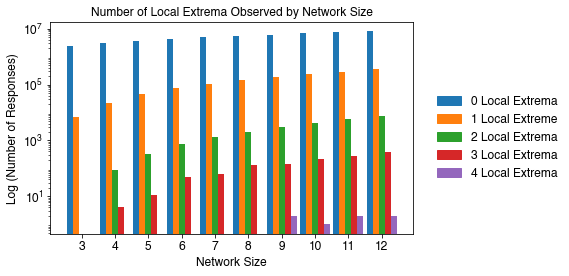

In [ ]:
fig, ax = plt.subplots()
rng = np.random.default_rng(seed=42)
cmap = cm.get_cmap('tab10')

num_curves_with_max_extrema_by_m = [0 for x in m_list]
max_num_extrema = max([np.max(number_local_extrema_by_network_size[m_i]) for m_i in range(len(m_list))])
width_per_bar = 0.9/(max_num_extrema+1)
middle_bar = np.median(list(range(max_num_extrema+1)))

for m_i, m in enumerate(m_list):
    number_local_extrema = number_local_extrema_by_network_size[m_i]
    num_curves_with_max_extrema_by_m[m_i] = [np.where(number_local_extrema==num_extrema)[0].shape[0] \
                                   for num_extrema in range(max_num_extrema+1)]

for num_extrema in range(max_num_extrema+1):
    offset = (num_extrema-middle_bar)*width_per_bar
    ax.bar(np.array(m_list)+offset, [num_curves_with_max_extrema_by_m[m_i][num_extrema] for m_i in range(len(m_list))], \
               width=width_per_bar,color=cmap(num_extrema),log=True)

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Log (Number of Responses)')
# _ = ax.set_title(f'Number of Local Extrema by Network Size ($10^{5}$ curves sampled)')
_ = ax.set_title(f'Number of Local Extrema Observed by Network Size')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(m) for m in m_list])
_ = ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))


patches={}
for num_extrema in range(max_num_extrema+1):
    if num_extrema==1:
        noun = 'Extreme'
    else:
        noun = 'Extrema'
    patches[f'{num_extrema}'] = \
        mpatches.Patch(color=cmap(num_extrema),label=f'{num_extrema} Local {noun}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'num_extrema_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

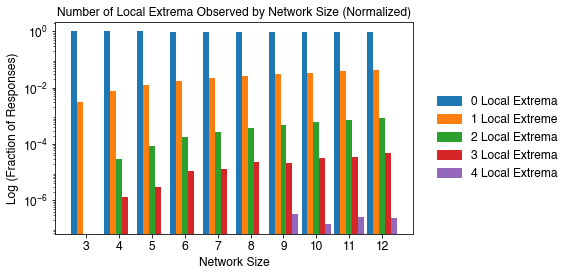

In [ ]:
fig, ax = plt.subplots()
rng = np.random.default_rng(seed=42)
cmap = cm.get_cmap('tab10')

fraction_curves_with_max_extrema_by_m = [0 for x in m_list]
max_num_extrema = max([np.max(number_local_extrema_by_network_size[m_i]) for m_i in range(len(m_list))])
width_per_bar = 0.9/(max_num_extrema+1)
middle_bar = np.median(list(range(max_num_extrema+1)))

for m_i, m in enumerate(m_list):
    curves_by_voxel = np.load(str(pathlib.Path(out_dir,f'{m}M_curves_by_voxel.npy')),allow_pickle=True)
    total_num_curves = np.sum([x.shape[0] for x in curves_by_voxel])
    number_local_extrema = number_local_extrema_by_network_size[m_i]
    fraction_curves_with_max_extrema_by_m[m_i] = [np.where(number_local_extrema==num_extrema)[0].shape[0]/\
                                    total_num_curves for num_extrema in range(max_num_extrema+1)]

for num_extrema in range(max_num_extrema+1):
    offset = (num_extrema-middle_bar)*width_per_bar
    ax.bar(np.array(m_list)+offset, [fraction_curves_with_max_extrema_by_m[m_i][num_extrema] for m_i in range(len(m_list))], \
               width=width_per_bar,color=cmap(num_extrema),log=True)

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Log (Fraction of Responses)')
_ = ax.set_title(f'Number of Local Extrema Observed by Network Size (Normalized)')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(m) for m in m_list])
_ = ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))


patches={}
for num_extrema in range(max_num_extrema+1):
    if num_extrema==1:
        noun = 'Extreme'
    else:
        noun = 'Extrema'
    patches[f'{num_extrema}'] = \
        mpatches.Patch(color=cmap(num_extrema),label=f'{num_extrema} Local {noun}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'num_extrema_by_network_size_norm'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

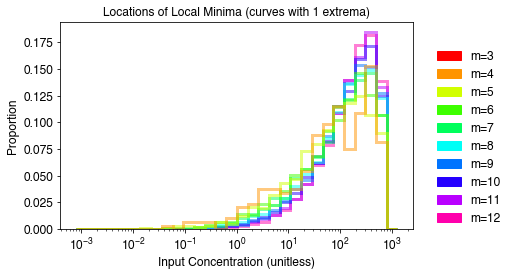

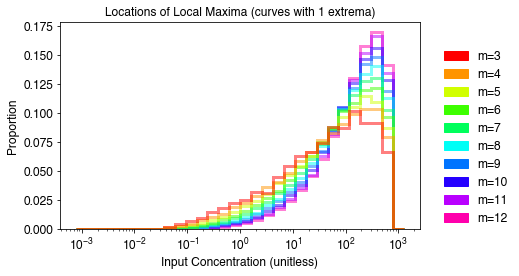

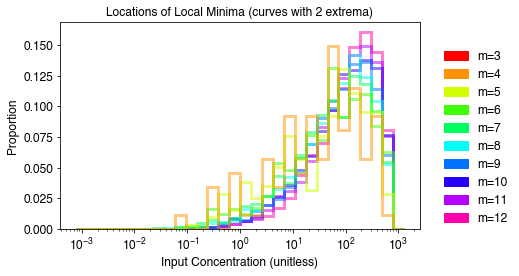

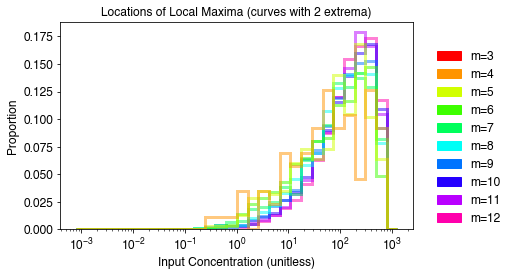

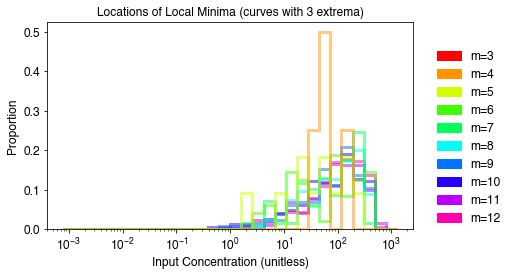

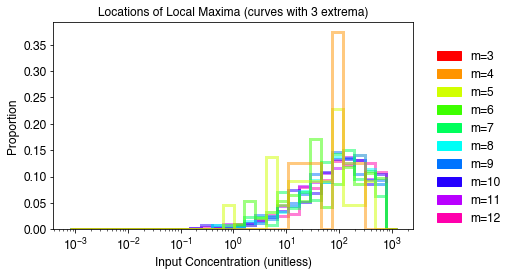

In [ ]:
x_points = np.logspace(input_lb,input_ub,t,endpoint=True)
extrema_position_bins = np.log10(x_points)-((input_ub-input_lb)/(2*t))
extrema_position_bins = np.array(list(extrema_position_bins)+[input_ub+((input_ub-input_lb)/(2*t))])
cmap = cm.get_cmap('hsv')

for num_local_extrema in range(1,4):
    # LOCAL MINS
    fig, ax = plt.subplots()
    for m in reversed(m_list):
        m_i = m_list.index(m)
        if len(local_min_positions_by_numextrema_by_m[num_local_extrema][m_i])==0:
            continue
        hist,_ = np.histogram(np.log10(x_points[local_min_positions_by_numextrema_by_m[num_local_extrema][m_i]]),\
                          bins =  extrema_position_bins,density=False) 
        hist = hist / np.sum(hist)
        ax.stairs(hist,10**extrema_position_bins,color=cmap(m_i/len(m_list)),linewidth=3,alpha=0.5)

    _ = ax.set_xlabel('Input Concentration (unitless)')
    _ = ax.set_ylabel('Proportion')
    _ = ax.set_title(f'Locations of Local Minima (curves with {num_local_extrema} extrema)')
    
    ax.set_xscale('log')
    patches={}
    for m_i,m in enumerate(m_list):
        patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/len(m_list)),label=f'm={m}')

    leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
        handles=list(patches.values()),\
        edgecolor='white')

    fig.patch.set_facecolor('white')
    filename = f'min_locations_{num_local_extrema}_extrema.png'
    plt.tight_layout()
    plt.savefig(str(pathlib.Path(out_dir,filename)),dpi=900,bbox_inches='tight')

    # LOCAL MAXS
    fig, ax = plt.subplots()
    for m in reversed(m_list):
        m_i = m_list.index(m)
        if len(local_max_positions_by_numextrema_by_m[num_local_extrema][m_i])==0:
            continue
        hist,_ = np.histogram(np.log10(x_points[local_max_positions_by_numextrema_by_m[num_local_extrema][m_i]]),\
                          bins =  extrema_position_bins,density=False) 
        hist = hist / np.sum(hist)
        ax.stairs(hist,10**extrema_position_bins,color=cmap(m_i/len(m_list)),linewidth=3,alpha=0.5)

    _ = ax.set_xlabel('Input Concentration (unitless)')
    _ = ax.set_ylabel('Proportion')
    _ = ax.set_title(f'Locations of Local Maxima (curves with {num_local_extrema} extrema)')

    ax.set_xscale('log')
    
    patches={}
    for m_i,m in enumerate(m_list):
        patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/len(m_list)),label=f'm={m}')

    leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
        handles=list(patches.values()),\
        edgecolor='white')
    
    filename = f'max_locations_{num_local_extrema}_extrema'
    plt.tight_layout()
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
all_local_extrema_positions_by_m = [[] for m_i in m_list]

x_points = np.logspace(input_lb,input_ub,t,endpoint=True)
extrema_position_bins = np.log10(x_points)-((input_ub-input_lb)/(2*t))
extrema_position_bins = np.array(list(extrema_position_bins)+[input_ub+((input_ub-input_lb)/(2*t))])
cmap = cm.get_cmap('hsv')

for extrema_i, num_local_extrema in enumerate(range(1,4)):
    for m_i, m in enumerate(m_list):
        all_local_extrema_positions_by_m[m_i].extend(local_min_positions_by_numextrema_by_m[extrema_i][m_i])
        all_local_extrema_positions_by_m[m_i].extend(local_max_positions_by_numextrema_by_m[extrema_i][m_i])

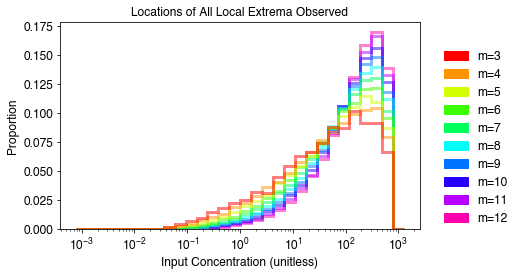

In [ ]:
x_points = np.logspace(input_lb,input_ub,t,endpoint=True)
extrema_position_bins = np.log10(x_points)-((input_ub-input_lb)/(2*t))
extrema_position_bins = np.array(list(extrema_position_bins)+[input_ub+((input_ub-input_lb)/(2*t))])
cmap = cm.get_cmap('hsv')


fig, ax = plt.subplots()
for m in reversed(m_list):
    m_i = m_list.index(m)
    hist,_ = np.histogram(np.log10(x_points[all_local_extrema_positions_by_m[m_i]]),\
                      bins =  extrema_position_bins,density=False) 
    hist = hist / np.sum(hist)
    ax.stairs(hist,10**extrema_position_bins,color=cmap(m_i/len(m_list)),linewidth=3,alpha=0.5)

_ = ax.set_xlabel('Input Concentration (unitless)')
_ = ax.set_ylabel('Proportion')
_ = ax.set_title(f'Locations of All Local Extrema Observed')
    
ax.set_xscale('log')
patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/len(m_list)),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'all_extrema_locations'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

### Propagation of Concentration Changes - Figure S3

Here we will analyze how far a concentration change appears to propagate in the network. For example, if a dimer is only connected to the input monomer through three edges (as the shortest path), can it still be perturbed by concentration changes in the input?

To answer this question, we must measure the distance of each monomer to the input (i.e., the shortest path)

In [ ]:
min_affinity = 1e-5 # Affinity cutoff to be counted as an "edge"

for m_i, m in enumerate(m_list):
    print(f"Working on m={m}")
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M',f'K_A_param_sets.npy')),allow_pickle=True)
    distance_to_input_by_monomer_by_param_set = np.zeros((param_sets.shape[0],m-1))

    # Separate out edge types - heterodimer vs. homodimer
    homo_edges = []
    hetero_edges = []
    for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
        if combo[0]==combo[1]:
            homo_edges.append(i)
        else:
            hetero_edges.append(i)
    homo_edges = np.array(homo_edges)
    hetero_edges = np.array(hetero_edges)
    possible_hetero_edges = np.array(list(itertools.combinations(range(m),r=2)))
    # Construct base graph in Networkx
    G_base = nx.Graph()
    G_base.add_nodes_from(list(range(m)))
    for param_set in progressbar.progressbar(range(param_sets.shape[0])):
        # For each parameter set, construct the graph and compute the distance of each monomer to the input using nx.shortest_path_length
        G = G_base.copy()
        G.add_edges_from(possible_hetero_edges[np.where(param_sets[param_set,hetero_edges]>=min_affinity)[0]])
        distance_to_input_by_monomer_by_param_set[param_set] = np.array([nx.shortest_path_length(G, source=0, target=monomer) for monomer in range(1,m)])
    np.save(str(pathlib.Path(out_dir,f'{m}M_distance_to_input_by_monomer_by_param_set.npy')),distance_to_input_by_monomer_by_param_set)

In [ ]:
# Iterate over network sizes
for m in m_list:
    m_i = m_list.index(m)
    print(f"Working on m={m}")
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M',f'K_A_param_sets.npy')),allow_pickle=True)
    dimers_by_param_set = np.load(str(pathlib.Path(out_dir,f'{m}M_dimers_by_param_set.npy')),allow_pickle=True)
    # Load dataset where we calculated the distance of each monomer to the input
    distance_to_input_by_monomer_by_param_set = np.load(str(pathlib.Path(out_dir,f'{m}M_distance_to_input_by_monomer_by_param_set.npy')),allow_pickle=True)
    dist_to_input_by_param_set_by_dimer = np.full((param_sets.shape[0],num_combos_with_replacement(m,2)),-1)

    # Calculate dimer types
    homo_edges = []
    hetero_edges = []
    input_acc_heterodimers = []
    dimer_constituents = list(itertools.combinations_with_replacement(range(m),r=2))
    for i,combo in enumerate(dimer_constituents):
        if combo[0]==combo[1]:
            homo_edges.append(i)
        else:
            hetero_edges.append(i)
            if combo[0]==0 or combo[1]==0:
                input_acc_heterodimers.append(i)
    homo_edges = np.array(homo_edges)
    hetero_edges = np.array(hetero_edges)

    # Calculate the distance of each dimer to the input by taking the minimum of the distances of its monomers to the input
    for param_set in progressbar.progressbar(range(param_sets.shape[0])):
        # Start at 1 to ignore input heterodimer - will always be 0 away
        for dimer in range(1,num_combos_with_replacement(m,2)):
            if not dimers_by_param_set[param_set,dimer]:
                continue
            elif dimer==0 or dimer in input_acc_heterodimers:
                dist_to_input_by_param_set_by_dimer[param_set,dimer] = 0
            else:
                dist_to_input_by_param_set_by_dimer[param_set,dimer] = int(np.min([distance_to_input_by_monomer_by_param_set[param_set,dimer_constituents[dimer][0]-1],\
                                                                               distance_to_input_by_monomer_by_param_set[param_set,dimer_constituents[dimer][1]-1]]))
    np.save(str(pathlib.Path(out_dir,f'{m}M_'+'dist_to_input_by_param_set_by_dimer.npy')),dist_to_input_by_param_set_by_dimer)

Now, for each distance from the input, we will measure the fraction of all dimers that form at significant concentrations and change at least 10-fold in response to input

In [ ]:
dist_list = list(range(m_list[-1]))
unfiltered_curves_by_dist_from_input_allm = [0 for dist in dist_list]
filtered_curves_by_dist_from_input_allm = [0 for dist in dist_list]

# Iterate over network sizes
for m in m_list:
    m_i = m_list.index(m)
    print(f"Working on m={m}")
    curves_per_param_set = num_combos_with_replacement(m,2)
    dist_to_input_by_param_set_by_dimer = np.load(str(pathlib.Path(out_dir,f'{m}M_'+'dist_to_input_by_param_set_by_dimer.npy')),allow_pickle=True)
    dimers_by_param_set = np.load(str(pathlib.Path(out_dir,f'{m}M_dimers_by_param_set.npy')),allow_pickle=True)
    where_dimers = np.where(dimers_by_param_set.flatten())[0]
    unfiltered_curves_by_dist_from_input = [0 for dist in dist_list]
    filtered_curves_by_dist_from_input = [0 for dist in dist_list]
    num_S_all_chunks = len(S_all_filenames_by_m[m_i])
    # Iterate over chunks of S_all (responses), which were saved separately
    for S_all_chunk in range(num_S_all_chunks):
        univ_filter_map_filename = str(pathlib.Path(load_dir,f'{m}M',f'univ_filter_map_{S_all_chunk}.npy'))
        univ_filter_map = np.load(str(pathlib.Path(load_dir,f'{m}M',univ_filter_map_filename)),allow_pickle=True)
        where_dimers_this_chunk = where_dimers[np.where((where_dimers>=np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk]))\
                                             & (where_dimers<np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk+1])))]
        # Iterate over distances from input
        for dist_i,dist in enumerate(dist_list):
            where_dist = np.where(dist_to_input_by_param_set_by_dimer==dist)
            curve_idx_this_dist = where_dist[0]*curves_per_param_set + where_dist[1]
            curve_idx_this_dist_in_chunk = curve_idx_this_dist[np.where((curve_idx_this_dist>=np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk]))\
                                             & (curve_idx_this_dist<np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk+1])))] # Unfiltered IDs in chunk
            if curve_idx_this_dist_in_chunk.shape[0]==0:
                continue
            curve_idx_this_dist_passed_filter = \
                curve_idx_this_dist_in_chunk[np.isin(curve_idx_this_dist_in_chunk,univ_filter_map[:,0])] # Unfiltered IDs in chunk, starting at 0 in chunk, that passed filtering
            # Calculate number of unfiltered and filtered curves
            unfiltered_curves_by_dist_from_input[dist_i]+=np.intersect1d(curve_idx_this_dist_in_chunk,where_dimers_this_chunk).shape[0]
            filtered_curves_by_dist_from_input[dist_i]+=curve_idx_this_dist_passed_filter.shape[0]
            unfiltered_curves_by_dist_from_input_allm[dist_i]+=np.intersect1d(curve_idx_this_dist_in_chunk,where_dimers_this_chunk).shape[0]
            filtered_curves_by_dist_from_input_allm[dist_i]+=curve_idx_this_dist_passed_filter.shape[0]
    fraction_passed_filter_by_dist_from_input = np.divide(np.array(filtered_curves_by_dist_from_input),np.array(unfiltered_curves_by_dist_from_input),\
          out=np.zeros((len(filtered_curves_by_dist_from_input))), \
          where=np.array(unfiltered_curves_by_dist_from_input)!=0)
    np.save(str(pathlib.Path(out_dir,f'{m}M_'+'fraction_passed_filter_by_dist_from_input.npy')),fraction_passed_filter_by_dist_from_input)
fraction_passed_filter_by_dist_from_input_allm = np.divide(np.array(filtered_curves_by_dist_from_input_allm),np.array(unfiltered_curves_by_dist_from_input_allm),\
          out=np.zeros((len(filtered_curves_by_dist_from_input_allm))), \
          where=np.array(unfiltered_curves_by_dist_from_input_allm)!=0)
np.save(str(pathlib.Path(out_dir,f'fraction_passed_filter_by_dist_from_input_allm.npy')),fraction_passed_filter_by_dist_from_input_allm)

Working on m=3
Working on m=4
Working on m=5
Working on m=6
Working on m=7
Working on m=8
Working on m=9
Working on m=10
Working on m=11
Working on m=12


Plot:

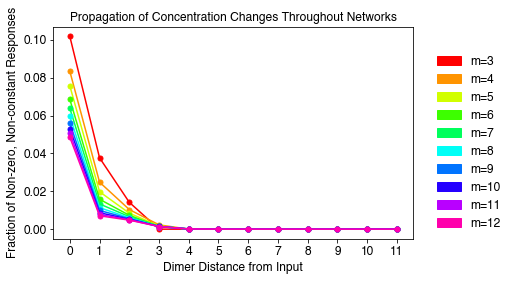

In [ ]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('hsv')

dist_list = list(range(m_list[-1]))

# Iterate over network sizes
for m in m_list:
    m_i = m_list.index(m)
    fraction_passed_filter_by_dist_from_input = np.load(str(pathlib.Path(out_dir,f'fraction_passed_filter_by_dist_from_input.npy')),allow_pickle=True)
    ax.plot(dist_list,fraction_passed_filter_by_dist_from_input,color=cmap(m_i/(len(m_list))),marker='.',markersize=10,linestyle='-')

_ = ax.set_xlabel('Dimer Distance from Input')
_ = ax.set_ylabel('Fraction of Non-zero, Non-constant Responses')
_ = ax.set_title('Propagation of Concentration Changes Throughout Networks')
_ = ax.set_xticks(dist_list)
_ = ax.set_xticklabels([str(dist) for dist in dist_list])

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'fraction_passed_filter_by_dist_from_input_by_m'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

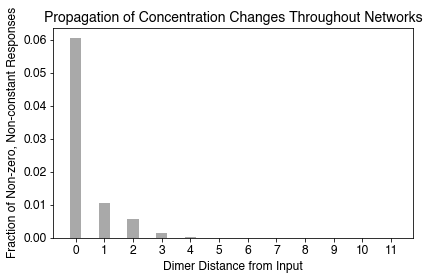

In [ ]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('hsv')

dist_list = list(range(m_list[-1]))
fraction_passed_filter_by_dist_from_input_allm = np.load(str(pathlib.Path(out_dir,f'fraction_passed_filter_by_dist_from_input_allm.npy')),allow_pickle=True)
ax.bar(dist_list,fraction_passed_filter_by_dist_from_input_allm,width=0.4,color='darkgray')

_ = ax.set_xlabel('Dimer Distance from Input')
_ = ax.set_ylabel('Fraction of Non-zero, Non-constant Responses')
_ = ax.set_title('Propagation of Concentration Changes Throughout Networks')
_ = ax.set_xticks(dist_list)
_ = ax.set_xticklabels([str(dist) for dist in dist_list])

filename = f'fraction_passed_filter_by_dist_from_input'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

The above analysis calculated the fraction of all dimers - excluding those with no affinity - that form at significant concentrations and change in concentration at least 10-fold. 

However, while easy to calculate, this metric isn't exactly what we want.

We want to know, of all dimers that form at significant concentrations, the fraction that change at least 10-fold.

In [ ]:
dist_list = list(range(m_list[-1]))
nonzero_curves_by_dist_from_input_allm = [0 for dist in dist_list]
filtered_curves_by_dist_from_input_allm = [0 for dist in dist_list]

min_conc = 10**input_lb # Minimum concentration to be considered nonzero

# Iterate over network sizes
for m in m_list:
    m_i = m_list.index(m)
    print(f"Working on m={m}")
    curves_per_param_set = num_combos_with_replacement(m,2)
    # dist_to_input_by_param_set_by_dimer = np.load(str(pathlib.Path(out_dir,f'{m}M_'+'dist_to_input_by_param_set_by_dimer.npy')),allow_pickle=True)
    # dimers_by_param_set = np.load(str(pathlib.Path(out_dir,f'{m}M_dimers_by_param_set.npy')),allow_pickle=True)
    dist_to_input_by_param_set_by_dimer = np.load(str(pathlib.Path(analysis_load_dir,f'{m}M_'+'dist_to_input_by_param_set_by_dimer.npy')),allow_pickle=True)
    dimers_by_param_set = np.load(str(pathlib.Path(analysis_load_dir,f'{m}M_dimers_by_param_set.npy')),allow_pickle=True)
    where_dimers = np.where(dimers_by_param_set.flatten())[0]
    unfiltered_curves_by_dist_from_input = [0 for dist in dist_list] # Only including dimers with some affinity
    nonzero_curves_by_dist_from_input = [0 for dist in dist_list]
    filtered_curves_by_dist_from_input = [0 for dist in dist_list]
    num_S_all_chunks = len(S_all_filenames_by_m[m_i])
    # Iterate over chunks of S_all (responses), which were saved separately
    for S_all_chunk in range(num_S_all_chunks):
        print(f"Working on S_all chunk {S_all_chunk}")
        S_all_temp = np.load(str(pathlib.Path(load_dir,f'{m}M',f'S_all_{S_all_chunk}.npy')),allow_pickle=True)
        univ_filter_map_filename = str(pathlib.Path(load_dir,f'{m}M',f'univ_filter_map_{S_all_chunk}.npy'))
        univ_filter_map = np.load(str(pathlib.Path(load_dir,f'{m}M',univ_filter_map_filename)),allow_pickle=True)
        where_dimers_this_chunk = where_dimers[np.where((where_dimers>=np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk]))\
                                             & (where_dimers<np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk+1])))]
        # Iterate over distances from input
        for dist_i,dist in enumerate(dist_list):
            where_dist = np.where(dist_to_input_by_param_set_by_dimer==dist)
            curve_idx_this_dist = where_dist[0]*curves_per_param_set + where_dist[1]
            curve_idx_this_dist_in_chunk = curve_idx_this_dist[np.where((curve_idx_this_dist>=np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk]))\
                                             & (curve_idx_this_dist<np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk+1])))] # Unfiltered IDs in chunk
            if curve_idx_this_dist_in_chunk.shape[0]==0:
                continue
            if S_all_chunk>0:
                curve_idx_this_dist_in_chunk = curve_idx_this_dist_in_chunk - ([0]+list(np.cumsum(all_curves_per_Sall_chunk_by_m[m_i])))[S_all_chunk] # Unfiltered IDs in chunk, starting at 0 in chunk,
            # Calculate number of nonzero and filtered (nonzero & perturbed) curves
            # Manually check whether these curves are nonzero
            num_nonzero_curves = np.where(np.any(S_all_temp[:,m:,:].reshape((t,-1),order='F').T\
                                    [curve_idx_this_dist_in_chunk]>min_conc,axis=1))[0].shape[0]
            nonzero_curves_by_dist_from_input[dist_i] = num_nonzero_curves
            nonzero_curves_by_dist_from_input_allm[dist_i]+=num_nonzero_curves
            
            num_filtered_curves = np.intersect1d(curve_idx_this_dist_in_chunk,univ_filter_map[:,0]).shape[0]
            filtered_curves_by_dist_from_input[dist_i] = num_filtered_curves
            filtered_curves_by_dist_from_input_allm[dist_i]+=num_filtered_curves

    fraction_perturbed_by_dist_from_input = np.divide(np.array(filtered_curves_by_dist_from_input),np.array(nonzero_curves_by_dist_from_input),\
          out=np.zeros((len(filtered_curves_by_dist_from_input))), \
          where=np.array(nonzero_curves_by_dist_from_input)!=0)
    np.save(str(pathlib.Path(out_dir,f'{m}M_'+'fraction_perturbed_by_dist_from_input.npy')),fraction_perturbed_by_dist_from_input)

fraction_perturbed_by_dist_from_input_allm = np.divide(np.array(filtered_curves_by_dist_from_input_allm),np.array(nonzero_curves_by_dist_from_input_allm),\
          out=np.zeros((len(filtered_curves_by_dist_from_input_allm))), \
          where=np.array(nonzero_curves_by_dist_from_input_allm)!=0)
np.save(str(pathlib.Path(out_dir,f'fraction_perturbed_by_dist_from_input_allm.npy')),fraction_perturbed_by_dist_from_input_allm)

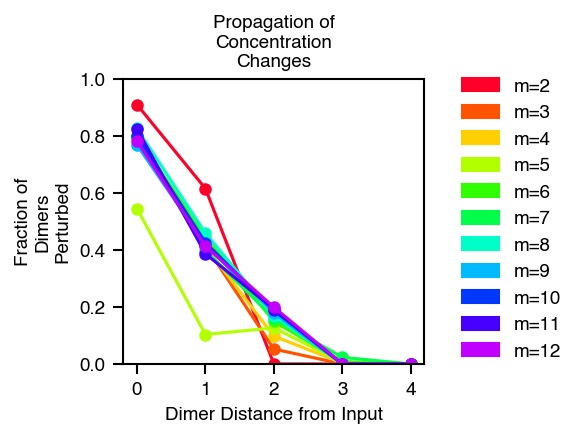

In [211]:
fig, ax = plt.subplots(figsize=(3,3))
cmap = plt.get_cmap('gist_rainbow')

dist_list = list(range(5))

# Iterate over network sizes
for m in m_list:
    m_i = m_list.index(m)
    fraction_perturbed_by_dist_from_input = np.load(str(pathlib.Path(out_dir,f'{m}M_fraction_perturbed_by_dist_from_input.npy')),allow_pickle=True)
    ax.plot(dist_list,fraction_perturbed_by_dist_from_input[:5],color=cmap(m_i/(len(m_list))),marker='.',markersize=10,linestyle='-')

_ = ax.set_xlabel('Dimer Distance from Input')
_ = ax.set_ylabel('Fraction of\nDimers\nPerturbed')
_ = ax.set_title('Propagation of\nConcentration\nChanges')
_ = ax.set_xticks(dist_list)
_ = ax.set_xticklabels([str(dist) for dist in dist_list])

ax.set_ylim([0,1])

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'fraction_perturbed_by_dist_from_input_by_m'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

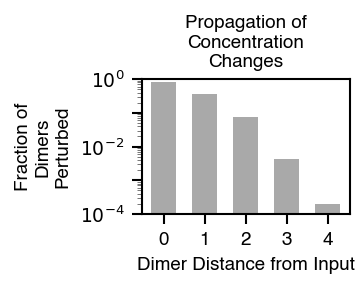

In [207]:
fig, ax = plt.subplots(figsize=(2.5,2))

dist_list = list(range(5))
fraction_perturbed_by_dist_from_input_allm = np.load(str(pathlib.Path(out_dir,f'fraction_perturbed_by_dist_from_input_allm.npy')),allow_pickle=True)
ax.bar(dist_list,fraction_perturbed_by_dist_from_input_allm[:5],width=0.6,color='darkgray')

_ = ax.set_xlabel('Dimer Distance from Input')
_ = ax.set_ylabel('Fraction of\nDimers\nPerturbed')
_ = ax.set_title('Propagation of\nConcentration\nChanges')
_ = ax.set_xticks(dist_list)
_ = ax.set_xticklabels([str(dist) for dist in dist_list])

ax.set_ylim([1e-4,1])
ax.set_yscale('log')

# Set ticks
set_simple_log_ticks(ax,which='y',log_lowerbound=-4,log_upperbound=0,max_labels=4)

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
ax.tick_params(axis='both', which='minor', length=2.5, width=0.25)   # Length and linewidth of minor ticks

filename = f'fraction_perturbed_by_dist_from_input'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Categorize Responses into Unique Functions ("Voxels")

### Define Functions

In [8]:
@ray.remote
def ray_digitize(S_all_filtered_processed,boundaries):
    return np.digitize(S_all_filtered_processed,boundaries)

In [ ]:
def calculate_unique_voxels(S_all_filtered_processed,boundaries,return_inverse=False,curves_per_chunk=5000):
    '''
    Given curves, categorize them into unique functions ("voxels") by binning the output at each input point.

    Uses np.digitize and ray for parallelization.
    
    Parameters:
    ----------
    S_all_filtered_processed: 2D array of shape (n_curves, t)
        Array of all responses
    boundaries: 1D array
        Array of boundaries at which to split output space.
    curves_per_chunk: Int
        Number of curves to consider at once.
    return_inverse: Bool
        Whether to return unique_inverse, a map of which curve went into which unique voxel.
        
    Returns:
    --------
    unique_voxels: 2D array of shape (n_unique_voxels, t)
        Array of all unique voxels found
    unique_inverse: 1D array of shape (n_curves,)
        Array describing, for each curve in the original dataset, which voxel in 
        unique_voxels it was assigned to.
    '''
    n_digitize_chunks = math.ceil(S_all_filtered_processed.shape[0]/curves_per_chunk)
    voxels = np.empty((S_all_filtered_processed.shape[0],S_all_filtered_processed.shape[1]))
    digitize_futures = []
    for chunk in range(n_digitize_chunks):
        digitize_futures.append(ray_digitize.remote(S_all_filtered_processed[chunk*curves_per_chunk:(chunk+1)*curves_per_chunk,:],\
                                boundaries))
    for chunk in range(n_digitize_chunks):
        voxels[chunk*curves_per_chunk:(chunk+1)*curves_per_chunk,:] = ray.get(digitize_futures[chunk])
    return np.unique(voxels,axis=0,return_inverse=return_inverse)

In [11]:
def calculate_voxel_overlap(unique_voxels_1, unique_voxels_2):
    '''
    Given two sets of unique functions, calculate the number of functions common to both sets.
    '''
    n1 = unique_voxels_1.shape[0]
    n2 = unique_voxels_2.shape[0]
    unique_voxels_joint = np.unique(np.concatenate((unique_voxels_1,unique_voxels_2),axis=0),axis=0,return_inverse=False)
    n_joint = unique_voxels_joint.shape[0]
    return n1+n2-n_joint

### Unique Functions by Network Size - Figure 4A, S3

This section performs the initial categorization of response functions; subsequent sections will draw from the saved files.

In [13]:
input_lb = -3 # Lower bound of input space in log scale
input_ub = 3 # Upper bound of input space in log scale
t = 30 # Number of input points
t_voxels = 6 # Number of input points to use for voxel calculation (e.g., 5 input points grouped in each voxel)

min_affinity=1e-5 # Affinity threshold for considering a dimer to be possible

In [14]:
# Directory to load data from
load_dir = '/home/ubuntu/Data/20221108_1input_randomParamset'

In [15]:
# Network sizes to test
m_list = list(range(2,13))

In [ ]:
# Load, if necessary
S_all_filenames_by_m = np.load(str(pathlib.Path(load_dir,'S_all_filenames_by_m.npy')),allow_pickle=True)
all_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'all_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
unfiltered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'unfiltered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
nonzero_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'nonzero_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
filtered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'filtered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)

In [ ]:
num_unfiltered_curves_by_m = [np.sum(unfiltered_curves_per_Sall_chunk_by_m[m_i]) for m_i, m in enumerate(m_list)]
num_nonzero_curves_by_m = [np.sum(nonzero_curves_per_Sall_chunk_by_m[m_i]) for m_i, m in enumerate(m_list)]
num_filtered_curves_by_m = [np.sum(filtered_curves_per_Sall_chunk_by_m[m_i]) for m_i, m in enumerate(m_list)]

In [ ]:
fraction_passed_filtering_by_m = np.divide(num_filtered_curves_by_m,num_unfiltered_curves_by_m)
fraction_nonzero = np.divide(num_nonzero_curves_by_m,num_unfiltered_curves_by_m)
fraction_nonzero_constant = np.divide(np.array(num_nonzero_curves_by_m)-np.array(num_filtered_curves_by_m),num_unfiltered_curves_by_m)

In [ ]:
# Define voxels
boundaries = np.logspace(input_lb,input_ub,t_voxels+1,endpoint=True)[1:-1]

In [ ]:
num_unique_voxels_by_m = []

# Iterate over network sizes
for m in m_list:
    m_i = m_list.index(m)
    print(f"Working on m={m}")
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M',f'K_A_param_sets.npy')),allow_pickle=True)
    S_all_filenames = S_all_filenames_by_m[m_i]
    num_S_all_chunks = len(S_all_filenames)
    # Iterate over chunks of S_all (the responses), which were saved across several files
    for S_all_chunk in range(num_S_all_chunks):
        # Load:
        S_all_processed_filtered = np.load(str(pathlib.Path(load_dir,f'{m}M',f'S_all_processed_filtered_{S_all_chunk}.npy')),allow_pickle=True)
        # Average into voxels
        S_all_processed_filtered_averaged = np.zeros((S_all_processed_filtered.shape[0],t_voxels))
        points_to_average = int(t//t_voxels)
        if t%t_voxels!=0:
            print("t_voxels must be integer factor of t")
        for input1 in range(t_voxels):
            S_all_processed_filtered_averaged[:,input1] = 10**np.mean(np.log10(S_all_processed_filtered[:,\
                                                                            (input1*points_to_average):(input1*points_to_average)+points_to_average]),axis=1)
        if S_all_chunk==0:
            unique_voxels,unique_inverse = calculate_unique_voxels(S_all_processed_filtered_averaged,boundaries,return_inverse=True)
        else:
            # Get unique voxels and map for this chunk
            unique_voxels_temp,unique_inverse_temp = calculate_unique_voxels(S_all_processed_filtered_averaged,boundaries,return_inverse=True)
            # Then calculate the unique voxels on the whole set
            meta_unique_voxels,meta_unique_inverse = np.unique(np.concatenate((unique_voxels,unique_voxels_temp),\
                                                     axis=0),axis=0,return_inverse=True)
            # Create a map describing how the unique voxels changed from the two subsets to the superset
            meta_unique_inverse_map = dict(np.concatenate((np.expand_dims(np.arange(meta_unique_inverse.shape[0]),axis=1),np.expand_dims(meta_unique_inverse,axis=1)),axis=1))
            # Translate the unique_inverse files into new, meta-clustered indices
            unique_inverse2 = np.vectorize(meta_unique_inverse_map.get)(unique_inverse)
            unique_inverse_temp2 = np.vectorize(meta_unique_inverse_map.get)(unique_inverse_temp+unique_voxels.shape[0])
            # Recreate objects after meta-clustering
            unique_voxels = meta_unique_voxels
            unique_inverse = np.concatenate((unique_inverse2,unique_inverse_temp2),axis=0)
    if num_S_all_chunks>1:
        del unique_voxels_temp,unique_inverse_temp,meta_unique_voxels,meta_unique_inverse,unique_inverse2, unique_inverse_temp2
    n_unique_voxels = unique_voxels.shape[0]
    num_unique_voxels_by_m.append(unique_voxels.shape[0])
    np.save(str(pathlib.Path(out_dir,f'{m}M_unique_voxels.npy')),unique_voxels)
    print("Calculating Voxel Averages")
    # clustered_responses = [np.empty((0,t)) for x in range(n_unique_voxels)]
    curves_by_voxel = []
    voxel_averages = np.zeros((n_unique_voxels,t))
    num_curves_per_voxel = np.zeros((n_unique_voxels,))
    for unique_voxel in range(n_unique_voxels):
        # Create curves_by_voxel array to map curves to voxels
        curves_by_voxel.append(np.where(unique_inverse==unique_voxel)[0])
    # For each voxel, calculate the average response in log space (need to iterate over S_all chunks)
    for S_all_chunk in range(num_S_all_chunks):
        S_all_processed_filtered = np.load(str(pathlib.Path(load_dir,f'{m}M',f'S_all_processed_filtered_{S_all_chunk}.npy')),allow_pickle=True)
        for unique_voxel in range(n_unique_voxels):
            curves_by_voxel_this_chunk = curves_by_voxel[unique_voxel][np.where((curves_by_voxel[unique_voxel]>=np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk]))\
                                     & (curves_by_voxel[unique_voxel]<np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk+1])))]
            curves_by_voxel_this_chunk = (curves_by_voxel_this_chunk-np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64)
            clustered_responses_temp = S_all_processed_filtered[curves_by_voxel_this_chunk,:]
            if clustered_responses_temp.shape[0]==0:
                continue
            # clustered_responses[unique_voxel] = np.append(clustered_responses[unique_voxel],clustered_responses_temp,axis=0)
            # Take average in log space
            if np.all(voxel_averages[unique_voxel,:]==0):
                voxel_averages[unique_voxel,:] = np.expand_dims(10**np.mean(np.log10(clustered_responses_temp),axis=0),axis=0)
            else:
                # If there were some responses from prior voxels, take a weighted average with those
                voxel_averages[unique_voxel,:] = 10**np.average(np.concatenate((np.expand_dims(np.log10(voxel_averages[unique_voxel,:]),axis=0),\
                                                                           np.expand_dims(np.mean(np.log10(clustered_responses_temp),axis=0),axis=0)),axis=0),\
                                                                           weights = np.array([num_curves_per_voxel[unique_voxel],clustered_responses_temp.shape[0]]),\
                                                                           axis=0)
            num_curves_per_voxel[unique_voxel]+=clustered_responses_temp.shape[0]
    np.save(str(pathlib.Path(out_dir,f'{m}M_curves_by_voxel.npy')),curves_by_voxel)
    np.save(str(pathlib.Path(out_dir,f'{m}M_voxel_averages.npy')),voxel_averages)

In [ ]:
np.save(str(pathlib.Path(out_dir,f'num_unique_voxels_by_m.npy')),num_unique_voxels_by_m)

In [ ]:
num_unique_voxels_by_m = np.load(str(pathlib.Path(out_dir,f'num_unique_voxels_by_m.npy')),allow_pickle=True)

Now create the relevant plots:

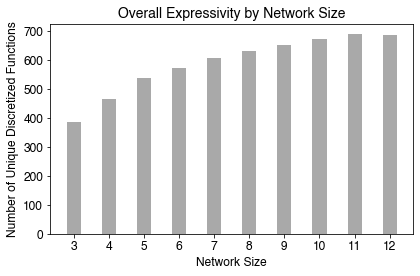

In [ ]:
fig, ax = plt.subplots()

ax.bar(m_list,num_unique_voxels_by_m,width=0.4,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Number of Unique Discretized Functions')
_ = ax.set_title('Overall Expressivity by Network Size')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(m) for m in m_list])


filename = f'num_unique_voxels_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

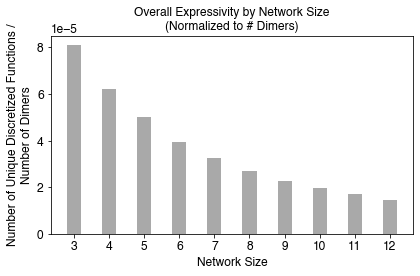

In [ ]:
fig, ax = plt.subplots()

ax.bar(m_list,[num_unique_voxels_by_m[m_i]/num_unfiltered_curves_by_m[m_i]\
               for m_i in range(len(m_list))],width=0.4,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Number of Unique Discretized Functions /\nNumber of Dimers')
_ = ax.set_title('Overall Expressivity by Network Size\n(Normalized to # Dimers)')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(m) for m in m_list])

filename = f'num_unique_voxels_by_network_size_unfilt_normalized'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

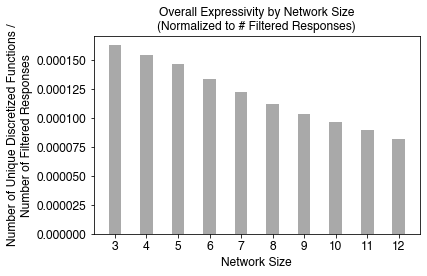

In [ ]:
fig, ax = plt.subplots()

ax.bar(m_list,[num_unique_voxels_by_m[m_i]/num_filtered_curves_by_m[m_i]\
               for m_i in range(len(m_list))],width=0.4,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Number of Unique Discretized Functions /\nNumber of Filtered Responses')
_ = ax.set_title('Overall Expressivity by Network Size\n(Normalized to # Filtered Responses)')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(m) for m in m_list])

filename = f'num_unique_voxels_by_network_size_filt_normalized'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

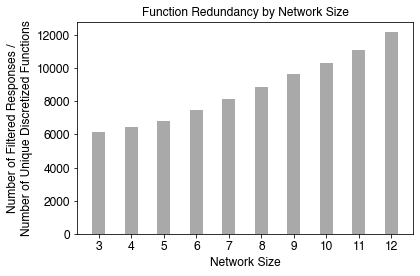

In [ ]:
fig, ax = plt.subplots()

ax.bar(m_list,[num_filtered_curves_by_m[m_i]/num_unique_voxels_by_m[m_i]\
               for m_i in range(len(m_list))],width=0.4,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Number of Filtered Responses /\nNumber of Unique Discretized Functions')
_ = ax.set_title('Function Redundancy by Network Size')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(m) for m in m_list])

filename = f'redundancy_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

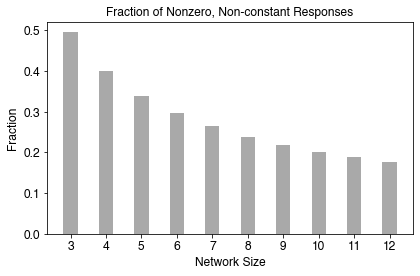

In [ ]:
fig, ax = plt.subplots()

ax.bar(m_list,fraction_passed_filtering_by_m,width=0.4,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Fraction')
_ = ax.set_title('Fraction of Nonzero, Non-constant Responses')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(m) for m in m_list])

filename = f'fraction_passed_filter_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

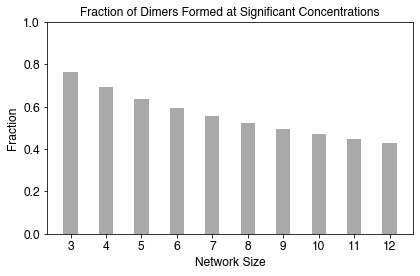

In [ ]:
fig, ax = plt.subplots()

ax.bar(m_list,fraction_nonzero,width=0.4,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Fraction')
_ = ax.set_title('Fraction of Dimers Formed at Significant Concentrations')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(m) for m in m_list])
_ = ax.set_ylim([0,1])

filename = f'fraction_nonzero_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

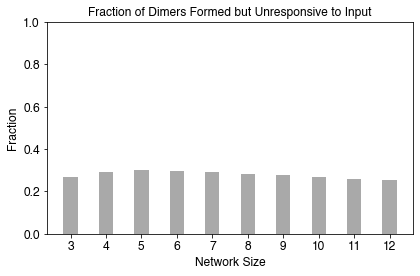

In [ ]:
fig, ax = plt.subplots()

ax.bar(m_list,fraction_nonzero_constant,width=0.4,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Fraction')
_ = ax.set_title('Fraction of Dimers Formed but Unresponsive to Input')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(m) for m in m_list])
_ = ax.set_ylim([0,1])

filename = f'fraction_nonzero_constant_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

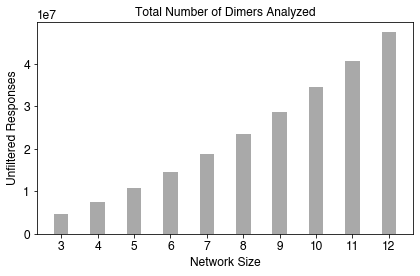

In [ ]:
fig, ax = plt.subplots()

ax.bar(m_list,num_unfiltered_curves_by_m,width=0.4,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Unfiltered Responses')
_ = ax.set_title('Total Number of Dimers Analyzed')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(m) for m in m_list])

filename = f'num_unfiltered_curves_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

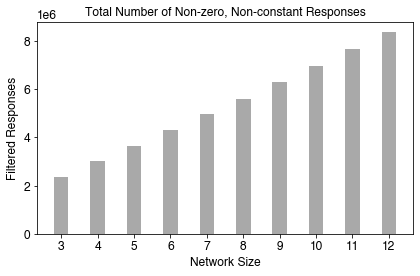

In [ ]:
fig, ax = plt.subplots()

ax.bar(m_list,num_filtered_curves_by_m,width=0.4,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Filtered Responses')
_ = ax.set_title('Total Number of Non-zero, Non-constant Responses')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(m) for m in m_list])

filename = f'num_filtered_curves_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

And now calculate overlaps in the expressivity of different network sizes:

In [ ]:
voxel_overlaps = np.zeros((len(m_list),len(m_list)))
voxel_overlap_fractions = np.zeros((len(m_list),len(m_list)))

num_unique_voxels_by_m = np.zeros((len(m_list),))

for m_i_1, m_1 in enumerate(m_list):
    unique_voxels_1 = np.load(str(pathlib.Path(out_dir,f'{m_1}M_unique_voxels.npy')),allow_pickle=True)
    num_unique_voxels_by_m[m_i_1] = unique_voxels_1.shape[0]
    for m_i_2, m_2 in enumerate(m_list):
        unique_voxels_2 = np.load(str(pathlib.Path(out_dir,f'{m_2}M_unique_voxels.npy')),allow_pickle=True)
        voxel_overlaps[m_i_1,m_i_2] = calculate_voxel_overlap(unique_voxels_1, unique_voxels_2)
        voxel_overlaps[m_i_2,m_i_1] = voxel_overlaps[m_i_1,m_i_2]
for m_i_1, m_1 in enumerate(m_list):
    for m_i_2, m_2 in enumerate(m_list):
        # Calculate overlap as fraction of 1
        voxel_overlap_fractions[m_i_1,m_i_2] = \
                voxel_overlaps[m_i_1,m_i_2]/num_unique_voxels_by_m[m_i_1]

np.save(str(pathlib.Path(out_dir,f'network_size_voxel_overlaps.npy')),voxel_overlaps)
np.save(str(pathlib.Path(out_dir,f'network_size_voxel_overlap_fractions.npy')),voxel_overlap_fractions)

In [ ]:
voxel_overlaps = np.load(str(pathlib.Path(out_dir,f'network_size_voxel_overlaps.npy')),allow_pickle=True)
voxel_overlap_fractions = np.load(str(pathlib.Path(out_dir,f'network_size_voxel_overlap_fractions.npy')),allow_pickle=True)

And plot:

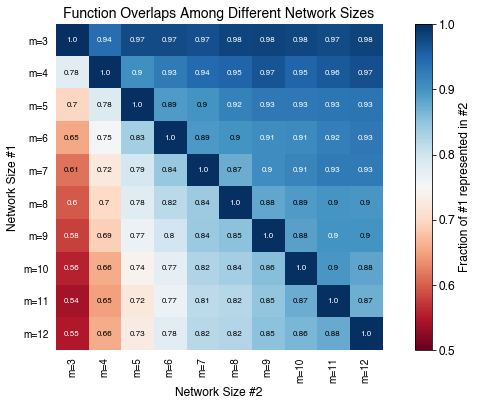

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

cmap = cm.get_cmap('RdBu').copy()

vmin = 0.05*(np.min(voxel_overlap_fractions)//0.05)
vmax = 1
matrix = ax.matshow(voxel_overlap_fractions,cmap = cmap,vmin=vmin,vmax=vmax)

for (j,i),label in np.ndenumerate(voxel_overlap_fractions):
    if label>(vmin+(0.2*(vmax-vmin))) and label<(vmin+(0.8*(vmax-vmin))):
        color='black'
    else:
        color='white'
    ax.text(i,j,round(label,2),ha='center',va='center',fontsize=8,color=color)

labels = [f'm={m}' for m in m_list]

ax.set_xticks(list(range(len(m_list))))
ax.set_xticklabels(labels,fontsize=10,rotation=90)
ax.xaxis.set_ticks_position("bottom")

ax.set_yticks(list(range(len(m_list))))
ax.set_yticklabels(labels,fontsize=10)

plt.tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,         
    right=False,
    left=False
 )
ax.spines.right.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.spines.top.set_visible(False)

fig.colorbar(matrix, ax=ax,label='Fraction of #1 represented in #2')

_ = ax.set_xlabel('Network Size #2')
_ = ax.set_ylabel('Network Size #1')
_ = ax.set_title(f'Function Overlaps Among Different Network Sizes',fontsize=14)

filename = f'network_size_voxel_overlaps'
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

### Plot an example "unique function" (voxel) - Figure 4A

In [ ]:
m = 12
m_i = m_list.index(m)

In [ ]:
# Load, if necessary
S_all_filenames_by_m = np.load(str(pathlib.Path(load_dir,'S_all_filenames_by_m.npy')),allow_pickle=True)
all_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'all_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
unfiltered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'unfiltered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
nonzero_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'nonzero_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
filtered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'filtered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)

In [ ]:
# Define voxels
boundaries = np.logspace(input_lb,input_ub,t_voxels+1,endpoint=True)[1:-1]

In [ ]:
S_all_filenames = S_all_filenames_by_m[m_i]
num_S_all_chunks = len(S_all_filenames)

S_all_chunk = 0
# Load:
S_all_processed_filtered = np.load(str(pathlib.Path(load_dir,f'{m}M',f'S_all_processed_filtered_{S_all_chunk}.npy')),allow_pickle=True)
unique_voxels = np.load(str(pathlib.Path(out_dir,f'{m}M_unique_voxels.npy')),allow_pickle=True)
curves_by_voxel = np.load(str(pathlib.Path(out_dir,f'{m}M_curves_by_voxel.npy')),allow_pickle=True)
voxel_averages = np.load(str(pathlib.Path(out_dir,f'{m}M_voxel_averages.npy')),allow_pickle=True)

We're going to look for functions based on their local extrema

In [ ]:
local_mins, local_maxs, pos_inflection_points, neg_inflection_points = \
    get_critical_points(np.log10(voxel_averages),extrema_threshold=0.2)
number_local_extrema = np.add(np.array([len(x) for x in local_mins]),np.array([len(x) for x in local_maxs]))

In [ ]:
# Voxels with and without bumps
bumps = sorted(range(voxel_averages.shape[0]),\
                         key = lambda x: (number_local_extrema[x]==1,curves_by_voxel[x].shape[0]==2),\
                         reverse=True)
nobumps = sorted(range(voxel_averages.shape[0]),\
                         key = lambda x: (number_local_extrema[x]==0,curves_by_voxel[x].shape[0]==2),\
                         reverse=True)

In [ ]:
# voxel1_to_plot = 28
voxel1_to_plot = 52
voxel2_to_plot = 116

In [ ]:
print("Number of curves in voxel 1:")
print(curves_by_voxel[voxel1_to_plot].shape[0])

print("Number of curves in voxel 2:")
print(curves_by_voxel[voxel2_to_plot].shape[0])

Number of curves in voxel 1:
28
Number of curves in voxel 2:
6605


In [ ]:
rng = np.random.default_rng()

In [ ]:
# Retrieve curves from the two unique functions

clustered_responses1 = np.empty((0,t))
# curves_to_plot1 = curves_by_voxel[voxel1_to_plot]
curves_to_plot1 = np.array([697005, 7915151])

# Iterate over chunks of S_all (the responses), which were saved across several files
for S_all_chunk in range(num_S_all_chunks):
    S_all_processed_filtered = np.load(str(pathlib.Path(load_dir,f'{m}M',f'S_all_processed_filtered_{S_all_chunk}.npy')),allow_pickle=True)
    curves_by_voxel_this_chunk = curves_to_plot1[np.where((curves_to_plot1>=np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk]))\
                             & (curves_to_plot1<np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk+1])))] # Filtered IDs in this chunk
    curves_by_voxel_this_chunk = (curves_by_voxel_this_chunk-np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64)  # Filtered IDs in this chunk, starting at 0 in chunk
    clustered_responses_temp = S_all_processed_filtered[curves_by_voxel_this_chunk,:]
    if clustered_responses_temp.shape[0]==0:
        continue
    clustered_responses1 = np.append(clustered_responses1,clustered_responses_temp,axis=0)

In [ ]:
print(curves_to_plot1)

array([ 697005, 7915151])

In [ ]:
clustered_responses2 = np.empty((0,t))
# curves_to_plot2 = curves_by_voxel[voxel2_to_plot]
curves_to_plot2 = np.array([192198, 7424845])

# Iterate over chunks of S_all (the responses), which were saved across several files
for S_all_chunk in range(num_S_all_chunks):
    S_all_processed_filtered = np.load(str(pathlib.Path(load_dir,f'{m}M',f'S_all_processed_filtered_{S_all_chunk}.npy')),allow_pickle=True)
    curves_by_voxel_this_chunk = curves_to_plot2[np.where((curves_to_plot2>=np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk]))\
                             & (curves_to_plot2<np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk+1])))] # Filtered IDs in this chunk
    curves_by_voxel_this_chunk = (curves_by_voxel_this_chunk-np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64)  # Filtered IDs in this chunk, starting at 0 in chunk
    clustered_responses_temp = S_all_processed_filtered[curves_by_voxel_this_chunk,:]
    if clustered_responses_temp.shape[0]==0:
        continue
    clustered_responses2 = np.append(clustered_responses2,clustered_responses_temp,axis=0)

In [ ]:
print(curves_to_plot2)

array([ 192198, 7424845])

In [ ]:
# Calculate which bins each function "hits"
voxel1_bins = unique_voxels[voxel1_to_plot].astype(np.int64)
voxel2_bins = unique_voxels[voxel2_to_plot].astype(np.int64)

Plot:

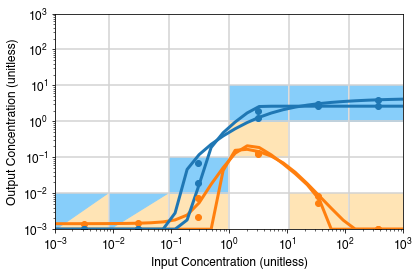

In [ ]:
fig,ax = plt.subplots()

x_points = np.logspace(input_lb,input_ub,t,endpoint=True)

cmap = plt.get_cmap('tab10')
bgcolors = ['moccasin','lightskyblue']
colors = [cmap(1),cmap(0)]

input_log_width = (input_ub-input_lb)/t
voxel_log_width = (input_ub-input_lb)/t_voxels
output_bin_log_width = (input_ub-input_lb)/t_voxels
x_anchors = 10**np.array([input_lb]+list((np.linspace(input_lb,input_ub+input_log_width,t_voxels+1,endpoint=True)-(input_log_width/2))[1:]))
y_anchors = [input_lb]+list(np.log10(boundaries))
y_anchors = 10**np.array(y_anchors)


# Plot bin boundaries
ax.vlines(x=x_anchors,ymin=1e-3,ymax=1e3,ls='-',colors=['lightgray'])
ax.hlines(y=boundaries,xmin=1e-3,xmax=1e3,ls='-',colors=['lightgray'])

# Plot bins hit in voxel
for i,voxel_bins in enumerate([voxel1_bins,voxel2_bins]):
    for voxel_id in range(t_voxels):
        x_anchor = x_anchors[voxel_id]
        x_anchor_log = np.log10(x_anchor)
        y_anchor = y_anchors[voxel_bins[voxel_id]]
        y_anchor_log = np.log10(y_anchor)
        if voxel_id==0 or voxel_id==t-1:
            # If first or last input point, only plot half the width
            width=10**(x_anchor_log+(voxel_log_width/2))-x_anchor
            log_width = voxel_log_width*(((t//t_voxels)-0.5)/(t//t_voxels))
        else:
            width=10**(x_anchor_log+voxel_log_width)-x_anchor
            log_width = voxel_log_width
        if voxel1_bins[voxel_id]==voxel2_bins[voxel_id]:
            # If both functions hit the same voxel
            if i==0:
                # If first function, plot the top triangle of the bin
                ax.add_patch(mpatches.Polygon(xy=np.array([[x_anchor,y_anchor],\
                                                          [10**(x_anchor_log+log_width),y_anchor],\
                                                          [10**(x_anchor_log+log_width),10**(y_anchor_log+output_bin_log_width)]]),color=bgcolors[i]))
            else:
                # If second function, plot the bottom triangle of the bin
                ax.add_patch(mpatches.Polygon(xy=np.array([[x_anchor,y_anchor],\
                                                          [x_anchor,10**(y_anchor_log+output_bin_log_width)],\
                                                          [10**(x_anchor_log+log_width),10**(y_anchor_log+output_bin_log_width)]]),color=bgcolors[i]))
                
        else:
            ax.add_patch(mpatches.Rectangle(xy=(x_anchor,y_anchor),\
                                            width=width,\
                                            height=10**(y_anchor_log+output_bin_log_width)-y_anchor,\
                                           color=bgcolors[i],alpha=1))

# Plot curves directly
ax.plot(x_points, np.array(clustered_responses1).T,marker='',ls='-',lw=3,color=colors[0],alpha=1)
ax.plot(x_points, np.array(clustered_responses2).T,marker='',ls='-',lw=3,color=colors[1],alpha=1)
for input1 in range(t_voxels):
    for curve in range(clustered_responses1.shape[0]):
        ax.plot(10**(np.log10(x_anchors[input1])+(voxel_log_width/2)),\
                10**np.mean(np.log10(clustered_responses1[curve][(input1*points_to_average):(input1*points_to_average)+points_to_average]),axis=0),\
               marker='.',ls='',markersize=12,color=colors[0])
    for curve in range(clustered_responses2.shape[0]):
        ax.plot(10**(np.log10(x_anchors[input1])+(voxel_log_width/2)),\
                10**np.mean(np.log10(clustered_responses2[curve][(input1*points_to_average):(input1*points_to_average)+points_to_average]),axis=0),\
               marker='.',ls='',markersize=12,color=colors[1])

ax.set_xscale('log')
ax.set_yscale('log')

_ = ax.set_xlim([1e-3,1e3])
_ = ax.set_ylim([1e-3,1e3])

_ = ax.set_xlabel('Input Concentration (unitless)')
_ = ax.set_ylabel('Output Concentration (unitless)')


filename = f'example_voxel'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

### Distribution of Function Prevalence - Figure S3

"Distribution of prevalence" asks, for a given unique function, how many random responses were categorized as performing that function

In [ ]:
m_list = list(range(2,13)) # Network sizes to analyze
t = 30 # Number of input points
t_voxels = 6 # Number of input regions for voxel categorization

In [ ]:
S_all_filenames_by_m = np.load(str(pathlib.Path(out_dir,'S_all_filenames_by_m.npy')),allow_pickle=True)
filtered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(out_dir,'filtered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
all_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(out_dir,'all_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)

We are going to calculate voxel prevalence not only within each network size (m), but across the whole dataset as well

In [ ]:
for m_i, m in enumerate(m_list):
    print(f"Working on m={m}")
    # Load data on voxels
    unique_voxels = np.load(str(pathlib.Path(out_dir,f'{m}M_unique_voxels.npy')),allow_pickle=True)
    curves_by_voxel = np.load(str(pathlib.Path(out_dir,f'{m}M_curves_by_voxel.npy')),allow_pickle=True)
    voxel_averages = np.load(str(pathlib.Path(out_dir,f'{m}M_voxel_averages.npy')),allow_pickle=True)
    # Calculate number of curves per voxel, within this network size
    num_curves_by_voxel = np.array([x.shape[0] for x in curves_by_voxel])
    num_curves_by_voxel_sorted = np.sort(num_curves_by_voxel)[::-1].astype(np.int64)
    np.save(str(pathlib.Path(out_dir,f'{m}M_num_curves_by_voxel_sorted.npy')),num_curves_by_voxel_sorted)
    if m_i ==0:
        # If first network size, initialize meta-variables
        new_meta_unique_voxels = unique_voxels.copy()
        new_meta_voxel_averages = voxel_averages.copy()
        new_num_curves_by_meta_voxel = np.array([x.shape[0] for x in curves_by_voxel])
    else:
        # Calculate unique voxels across whole dataset of network sizes
        new_meta_unique_voxels, new_meta_unique_inverse = np.unique(np.concatenate((meta_unique_voxels,unique_voxels),axis=0),axis=0,return_inverse=True)
        # Recalculate number of curves per voxel, across whole dataset of network sizes
        num_curves_by_meta_voxel = np.concatenate((num_curves_by_meta_voxel,np.zeros((new_meta_unique_voxels.shape[0]-meta_unique_voxels.shape[0]))))
        new_num_curves_by_meta_voxel = np.zeros((new_meta_unique_voxels.shape[0],))
        new_meta_voxel_averages = np.empty((new_meta_unique_voxels.shape[0],t))
        for old_voxel in range(meta_unique_voxels.shape[0]):
            #  If voxel was previously in dataset, append to old values
            corresponding_meta_voxel = new_meta_unique_inverse[old_voxel]
            new_num_curves_by_meta_voxel[corresponding_meta_voxel] += num_curves_by_meta_voxel[old_voxel]
            new_meta_voxel_averages[corresponding_meta_voxel,:] = meta_voxel_averages[old_voxel,:]
        for new_voxel in range(unique_voxels.shape[0]):
            #  If voxel is new, calculate new values
            num_new_curves = curves_by_voxel[new_voxel].shape[0]
            corresponding_meta_voxel = new_meta_unique_inverse[new_voxel+meta_unique_voxels.shape[0]]
            if np.where(new_meta_unique_inverse==corresponding_meta_voxel)[0].shape[0]==1:
                new_meta_voxel_averages[corresponding_meta_voxel,:] = voxel_averages[new_voxel,:]
            else:
                new_meta_voxel_averages[corresponding_meta_voxel,:] = 10**np.average(\
                        np.log10(np.vstack((new_meta_voxel_averages[corresponding_meta_voxel,:],\
                                        voxel_averages[new_voxel]))),axis=0,weights=\
                            np.array([new_num_curves_by_meta_voxel[corresponding_meta_voxel],\
                                     num_new_curves]))
            new_num_curves_by_meta_voxel[corresponding_meta_voxel] += num_new_curves
        
    meta_unique_voxels = new_meta_unique_voxels.copy()
    meta_voxel_averages = new_meta_voxel_averages.copy()
    num_curves_by_meta_voxel = new_num_curves_by_meta_voxel.copy()

Working on m=3
Working on m=4
Working on m=5
Working on m=6
Working on m=7
Working on m=8
Working on m=9
Working on m=10
Working on m=11
Working on m=12


In [ ]:
# Sort meta voxels by number of curves
num_curves_by_meta_voxel_sorted = np.sort(num_curves_by_meta_voxel)[::-1].astype(np.int64)
total_num_unique_voxels = meta_unique_voxels.shape[0]

In [ ]:
np.save(str(pathlib.Path(out_dir,f'num_curves_by_meta_voxel_sorted.npy')),num_curves_by_meta_voxel_sorted)

In [ ]:
num_curves_by_meta_voxel_sorted = np.load(str(pathlib.Path(out_dir,f'num_curves_by_meta_voxel_sorted.npy')),allow_pickle=True)

Plot overall:

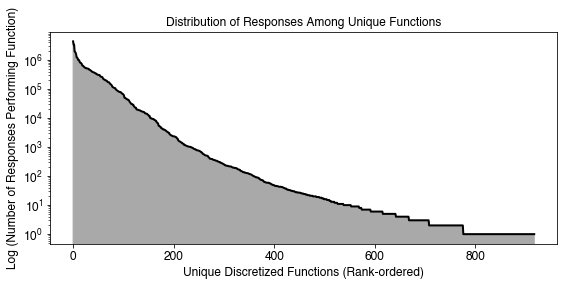

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(list(range(num_curves_by_meta_voxel_sorted.shape[0])),num_curves_by_meta_voxel_sorted,linewidth=2,color='k')
ax.fill_between(list(range(num_curves_by_meta_voxel_sorted.shape[0])),num_curves_by_meta_voxel_sorted,color='darkgray')

_ = ax.set_xlabel(f'Unique Discretized Functions (Rank-ordered)')
_ = ax.set_ylabel('Log (Number of Responses Performing Function)')
_ = ax.set_title('Distribution of Responses Among Unique Functions')

ax.set_yscale('log')

filename = f'voxel_size_distribution'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

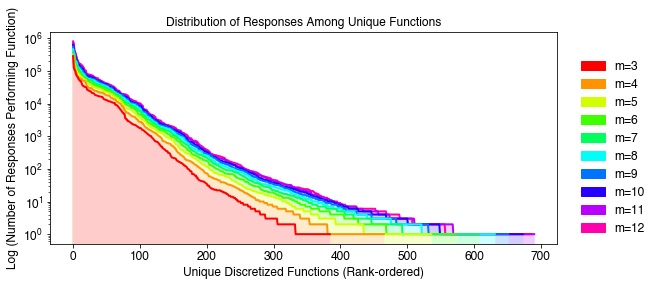

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
cmap = plt.get_cmap('hsv')

for m in reversed(m_list):
    m_i = m_list.index(m)
    num_curves_by_voxel_sorted = np.load(str(pathlib.Path(out_dir,f'{m}M_num_curves_by_voxel_sorted.npy')),allow_pickle=True)
    ax.plot(list(range(num_curves_by_voxel_sorted.shape[0])),num_curves_by_voxel_sorted,linewidth=2,color=cmap(m_i/len(m_list)))

_ = ax.set_xlabel(f'Unique Discretized Functions (Rank-ordered)')
_ = ax.set_ylabel('Log (Number of Responses Performing Function)')
_ = ax.set_title('Distribution of Responses Among Unique Functions')

ax.set_yscale('log')

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/len(m_list)),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'voxel_size_distribution_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

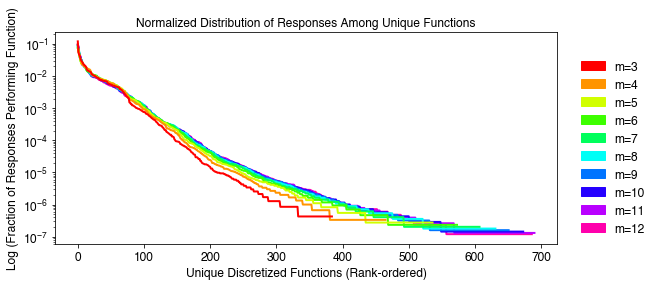

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
cmap = plt.get_cmap('hsv')

for m in reversed(m_list):
    m_i = m_list.index(m)
    curves_by_voxel = np.load(str(pathlib.Path(out_dir,f'{m}M_curves_by_voxel.npy')),allow_pickle=True)
    total_num_curves = np.sum([x.shape[0] for x in curves_by_voxel])
    num_curves_by_voxel_sorted = np.load(str(pathlib.Path(out_dir,f'{m}M_num_curves_by_voxel_sorted.npy')),allow_pickle=True)
    ax.plot(list(range(num_curves_by_voxel_sorted.shape[0])),[x/total_num_curves for x in num_curves_by_voxel_sorted],\
            linewidth=2,color=cmap(m_i/len(m_list)))

_ = ax.set_xlabel(f'Unique Discretized Functions (Rank-ordered)')
_ = ax.set_ylabel('Log (Fraction of Responses Performing Function)')
_ = ax.set_title('Normalized Distribution of Responses Among Unique Functions')

ax.set_yscale('log')

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/len(m_list)),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'voxel_size_distribution_by_network_size_norm'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

### Number of Unique Functions by Dimer Type - Figure S3

Here, we break down expressivity by "dimer type," i.e., input-accessory heterodimers, accessory homodimers, etc.

We will not re-calculate the voxels, but rather just analyze the existing dataset from the network size analysis

In [ ]:
m_list = list(range(2,13)) # Network sizes to analyze

In [ ]:
# Load, if necessary
S_all_filenames_by_m = np.load(str(pathlib.Path(load_dir,'S_all_filenames_by_m.npy')),allow_pickle=True)
all_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'all_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
unfiltered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'unfiltered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
nonzero_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'nonzero_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
filtered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'filtered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)

In [ ]:
# Define voxels
boundaries = np.logspace(input_lb,input_ub,t_voxels+1,endpoint=True)[1:-1]

In [ ]:
num_unique_voxels_by_species_type_by_m = [[] for x in range(4)]
num_unfiltered_curves_by_species_type_by_m = [[] for x in range(4)]
num_filtered_curves_by_species_type_by_m = [[] for x in range(4)]
for m_i, m in enumerate(m_list):
    print(f"Working on m={m}")
    # Load info on dataset
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M',f'K_A_param_sets.npy')),allow_pickle=True)
    unique_voxels = np.load(str(pathlib.Path(out_dir,f'{m}M_unique_voxels.npy')),allow_pickle=True)
    curves_by_voxel = np.load(str(pathlib.Path(out_dir,f'{m}M_curves_by_voxel.npy')),allow_pickle=True)
    dimers_by_param_set = np.load(str(pathlib.Path(out_dir,f'{m}M_dimers_by_param_set.npy')),allow_pickle=True)
    
    # Create unique_inverse mapping from curves to voxels
    unique_inverse = np.empty((np.sum(filtered_curves_per_Sall_chunk_by_m[m_i]),),dtype=np.int64)
    for voxel in range(curves_by_voxel.shape[0]):
        unique_inverse[curves_by_voxel[voxel]] = voxel
    
    num_sets = param_sets.shape[0]
    num_possible_num_edges = num_combos(m,r=2) - (m-1) + 1
    num_sets_per_num_edges = math.ceil(num_sets/num_possible_num_edges)

    # Calculate dimer types
    input_input_homodimer = []
    input_acc_heterodimers = []
    acc_acc_homodimers = []
    acc_acc_heterodimers = []

    for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
        if combo[0]==combo[1]:
            if combo[0]==0:
                input_input_homodimer.append(i)
            else:
                acc_acc_homodimers.append(i)
        else:
            if combo[0]==0 or combo[1]==0:
                input_acc_heterodimers.append(i)
            else:
                acc_acc_heterodimers.append(i)

    species_types = [input_input_homodimer,input_acc_heterodimers,acc_acc_homodimers,acc_acc_heterodimers]
    species_per_network = num_combos_with_replacement(m,r=2)
    num_S_all_chunks = len(S_all_filenames_by_m[m_i])
    unique_voxel_ids_by_species_type = []
    for species_type_i in range(4):
        # Identify curve indices for this species type
        num_curves_this_species_type = num_sets*len(species_types[species_type_i])
        curve_idx_this_species_type = np.zeros((num_curves_this_species_type,),dtype=np.int64)
        for species_i, species in enumerate(species_types[species_type_i]):
            curve_idx_this_species_type[np.linspace(0,num_curves_this_species_type,num_sets,endpoint=False,dtype=np.int64)+species_i]=\
                np.linspace(0,num_sets*species_per_network,num_sets,endpoint=False,dtype=np.int64)+species # Unfiltered IDs
        num_unfiltered_ids = np.sum(dimers_by_param_set.reshape((-1,))[curve_idx_this_species_type])
        num_filtered_ids = 0
        unique_voxel_ids = np.empty((0,))
        # Iterate over chunks of S_all (the responses), which were saved across several files
        for S_all_chunk in range(num_S_all_chunks):
            # Find curve indices of this species type in this chunk
            curve_idx_this_species_type_in_chunk = curve_idx_this_species_type[np.where((curve_idx_this_species_type>=np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk]))\
                                             & (curve_idx_this_species_type<np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk+1])))] # Unfiltered IDs in chunk
            if curve_idx_this_species_type_in_chunk.shape[0]==0:
                continue
            # S_all_processed_filtered = np.load(str(pathlib.Path(load_dir,f'{m}M',f'S_all_processed_filtered_{S_all_chunk}.npy')),allow_pickle=True)
            univ_filter_map_filename = str(pathlib.Path(load_dir,f'{m}M',f'univ_filter_map_{S_all_chunk}.npy'))
            univ_filter_map = np.load(univ_filter_map_filename,allow_pickle=True)
            curve_idx_this_species_type_in_chunk = (curve_idx_this_species_type_in_chunk-\
                                        np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64) # Unfiltered IDs in chunk, starting at 0 in chunk
            curve_idx_this_species_type_passed_filter = \
                curve_idx_this_species_type_in_chunk[np.isin(curve_idx_this_species_type_in_chunk,univ_filter_map[:,0])] # Unfiltered IDs in chunk, starting at 0 in chunk, that passed filtering
            curve_idx_this_species_type_filtered = univ_filter_map[np.isin(univ_filter_map[:,0],curve_idx_this_species_type_passed_filter)][:,1] # Filtered IDs in chunk, starting at 0 in chunk
            num_filtered_ids += curve_idx_this_species_type_filtered.shape[0]
            # S_all_subset = S_all_processed_filtered[curve_idx_this_species_type_filtered,:]
            # Knowing all the voxels for this subset of the data, calculate the unique indices of those voxels
            if unique_voxel_ids.shape[0]==0:
                # If first S_all chunk with any curves of this species type, initialize unique_voxel_ids
                unique_voxel_ids = np.unique(unique_inverse[(curve_idx_this_species_type_filtered+\
                                                             np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64)])
            else:
                # Otherwise, append to unique_voxel_ids
                unique_voxel_ids_temp = np.unique(unique_inverse[(curve_idx_this_species_type_filtered+\
                                                             np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64)])
                unique_voxel_ids = np.unique(np.concatenate((unique_voxel_ids,unique_voxel_ids_temp),\
                                                         axis=0),axis=0,return_inverse=False)
        unique_voxel_ids_by_species_type.append(unique_voxel_ids)
        if num_filtered_ids==0:
            num_unique_voxels_by_species_type_by_m[species_type_i].append(0)
            num_unfiltered_curves_by_species_type_by_m[species_type_i].append(num_unfiltered_ids)
            num_filtered_curves_by_species_type_by_m[species_type_i].append(num_filtered_ids)
        else:
            num_unique_voxels_by_species_type_by_m[species_type_i].append(unique_voxel_ids.shape[0])
            num_unfiltered_curves_by_species_type_by_m[species_type_i].append(num_unfiltered_ids)
            num_filtered_curves_by_species_type_by_m[species_type_i].append(num_filtered_ids)
        
    voxel_overlaps = np.zeros((4,4))
    voxel_overlap_fractions = np.zeros((4,4))

    # Calculate function overlaps between species types
    for species_type_i_1 in range(4):
        unique_voxel_ids_1 = unique_voxel_ids_by_species_type[species_type_i_1]
        for species_type_i_2 in range(4):
            unique_voxel_ids_2 = unique_voxel_ids_by_species_type[species_type_i_2]
            voxel_overlaps[species_type_i_1,species_type_i_2] = calculate_voxel_overlap(unique_voxel_ids_1, unique_voxel_ids_2)
            voxel_overlaps[species_type_i_2,species_type_i_1] = voxel_overlaps[species_type_i_1,species_type_i_2]
    for species_type_i_1 in range(4):
        for species_type_i_2 in range(4):
            # Calculate overlap as fraction of K_i_1
            voxel_overlap_fractions[species_type_i_1,species_type_i_2] = \
                    voxel_overlaps[species_type_i_1,species_type_i_2]/unique_voxel_ids_by_species_type[species_type_i_1].shape[0]

    np.save(str(pathlib.Path(out_dir,f'{m}M_voxel_overlaps_by_species_type.npy')),voxel_overlaps)
    np.save(str(pathlib.Path(out_dir,f'{m}M_voxel_overlap_fractions_by_species_type.npy')),voxel_overlap_fractions)

Working on m=3
Working on m=4
Working on m=5
Working on m=6
Working on m=7
Working on m=8
Working on m=9
Working on m=10
Working on m=11
Working on m=12


In [ ]:
fraction_passed_filter_by_species_type_by_m = [[num_filtered_curves_by_species_type_by_m[species_type_i][m_i]/\
                                                num_unfiltered_curves_by_species_type_by_m[species_type_i][m_i]\
                                               for m_i, m in enumerate(m_list)] \
                                               for species_type_i in range(4)]

In [ ]:
np.save(str(pathlib.Path(out_dir,f'num_unique_voxels_by_species_type_by_m.npy')),num_unique_voxels_by_species_type_by_m)
np.save(str(pathlib.Path(out_dir,f'num_unfiltered_curves_by_species_type_by_m.npy')),num_unfiltered_curves_by_species_type_by_m)
np.save(str(pathlib.Path(out_dir,f'num_filtered_curves_by_species_type_by_m.npy')),num_filtered_curves_by_species_type_by_m)
np.save(str(pathlib.Path(out_dir,f'fraction_passed_filter_by_species_type_by_m.npy')),fraction_passed_filter_by_species_type_by_m)

In [ ]:
num_unique_voxels_by_species_type_by_m = np.load(str(pathlib.Path(out_dir,f'num_unique_voxels_by_species_type_by_m.npy')),allow_pickle=True)
num_unfiltered_curves_by_species_type_by_m = np.load(str(pathlib.Path(out_dir,f'num_unfiltered_curves_by_species_type_by_m.npy')),allow_pickle=True)
num_filtered_curves_by_species_type_by_m = np.load(str(pathlib.Path(out_dir,f'num_filtered_curves_by_species_type_by_m.npy')),allow_pickle=True)
fraction_passed_filter_by_species_type_by_m = np.load(str(pathlib.Path(out_dir,f'fraction_passed_filter_by_species_type_by_m.npy')),allow_pickle=True)

Plot:

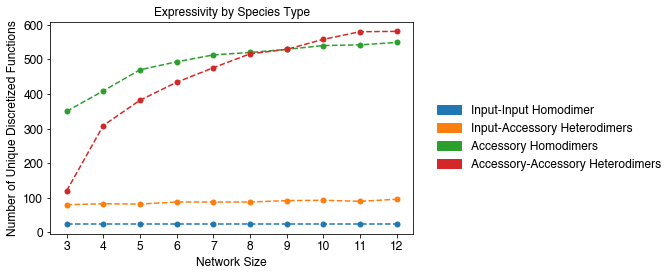

In [ ]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('tab10')

for species_type_i in range(4):
    ax.plot(m_list,num_unique_voxels_by_species_type_by_m[species_type_i],\
                marker='.',linestyle='--',markersize=12,markeredgewidth=0,color=cmap(species_type_i),alpha=1)

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Number of Unique Discretized Functions')
_ = ax.set_title(f'Expressivity by Species Type')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(x) for x in m_list])

patches={}
patches['input_input_homodimer'] = mpatches.Patch(color=cmap(0),label=f'Input-Input Homodimer')
patches['input_acc_heterodimers'] = mpatches.Patch(color=cmap(1),label=f'Input-Accessory Heterodimers')
patches['acc_acc_homodimers'] = mpatches.Patch(color=cmap(2),label=f'Accessory Homodimers')
patches['acc_acc_heterodimers'] = mpatches.Patch(color=cmap(3),label=f'Accessory-Accessory Heterodimers')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'num_unique_voxels_by_species_type'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

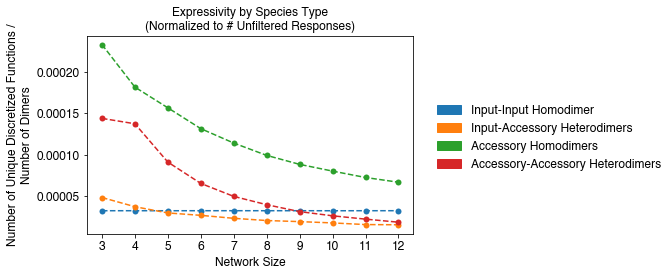

In [ ]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('tab10')

for species_type_i in range(4):
    ax.plot(m_list,np.divide(num_unique_voxels_by_species_type_by_m[species_type_i],num_unfiltered_curves_by_species_type_by_m[species_type_i]),\
                marker='.',linestyle='--',markersize=12,markeredgewidth=0,color=cmap(species_type_i),alpha=1)

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Number of Unique Discretized Functions /\nNumber of Dimers')
_ = ax.set_title(f'Expressivity by Species Type\n(Normalized to # Unfiltered Responses)')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(x) for x in m_list])

patches={}
patches['input_input_homodimer'] = mpatches.Patch(color=cmap(0),label=f'Input-Input Homodimer')
patches['input_acc_heterodimers'] = mpatches.Patch(color=cmap(1),label=f'Input-Accessory Heterodimers')
patches['acc_acc_homodimers'] = mpatches.Patch(color=cmap(2),label=f'Accessory Homodimers')
patches['acc_acc_heterodimers'] = mpatches.Patch(color=cmap(3),label=f'Accessory-Accessory Heterodimers')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'num_unique_voxels_by_species_type_unfilt_normalized'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

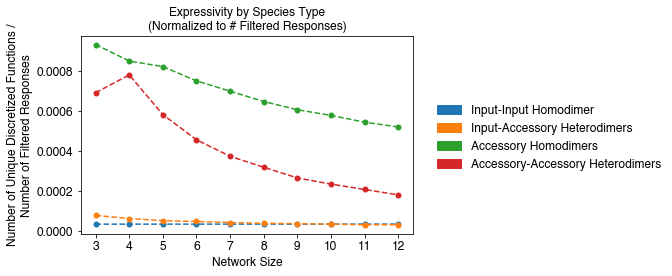

In [ ]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('tab10')

for species_type_i in range(4):
    ax.plot(m_list,np.divide(num_unique_voxels_by_species_type_by_m[species_type_i],num_filtered_curves_by_species_type_by_m[species_type_i]),\
                marker='.',linestyle='--',markersize=12,markeredgewidth=0,color=cmap(species_type_i),alpha=1)

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Number of Unique Discretized Functions /\nNumber of Filtered Responses')
_ = ax.set_title(f'Expressivity by Species Type\n(Normalized to # Filtered Responses)')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(x) for x in m_list])

patches={}
patches['input_input_homodimer'] = mpatches.Patch(color=cmap(0),label=f'Input-Input Homodimer')
patches['input_acc_heterodimers'] = mpatches.Patch(color=cmap(1),label=f'Input-Accessory Heterodimers')
patches['acc_acc_homodimers'] = mpatches.Patch(color=cmap(2),label=f'Accessory Homodimers')
patches['acc_acc_heterodimers'] = mpatches.Patch(color=cmap(3),label=f'Accessory-Accessory Heterodimers')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'num_unique_voxels_by_species_type_filt_normalized'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

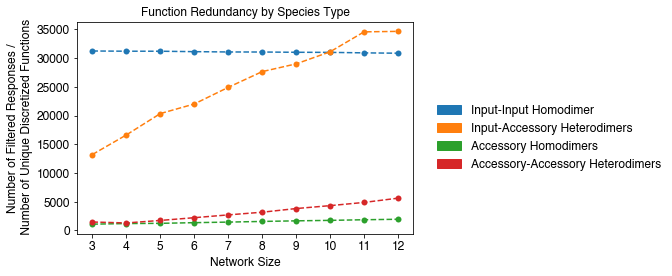

In [ ]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('tab10')

for species_type_i in range(4):
    ax.plot(m_list,np.divide(num_filtered_curves_by_species_type_by_m[species_type_i],num_unique_voxels_by_species_type_by_m[species_type_i]),\
                marker='.',linestyle='--',markersize=12,markeredgewidth=0,color=cmap(species_type_i),alpha=1)

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Number of Filtered Responses /\n Number of Unique Discretized Functions')
_ = ax.set_title(f'Function Redundancy by Species Type')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(x) for x in m_list])

patches={}
patches['input_input_homodimer'] = mpatches.Patch(color=cmap(0),label=f'Input-Input Homodimer')
patches['input_acc_heterodimers'] = mpatches.Patch(color=cmap(1),label=f'Input-Accessory Heterodimers')
patches['acc_acc_homodimers'] = mpatches.Patch(color=cmap(2),label=f'Accessory Homodimers')
patches['acc_acc_heterodimers'] = mpatches.Patch(color=cmap(3),label=f'Accessory-Accessory Heterodimers')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'redundancy_by_species_type'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

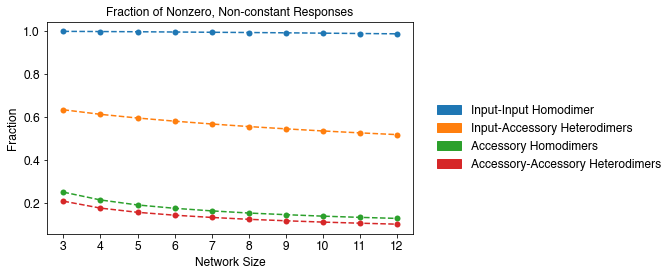

In [ ]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('tab10')

for species_type_i in range(4):
    ax.plot(m_list,fraction_passed_filter_by_species_type_by_m[species_type_i],\
                marker='.',linestyle='--',markersize=12,markeredgewidth=0,color=cmap(species_type_i),alpha=1)

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Fraction')
_ = ax.set_title('Fraction of Nonzero, Non-constant Responses')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(x) for x in m_list])

patches={}
patches['input_input_homodimer'] = mpatches.Patch(color=cmap(0),label=f'Input-Input Homodimer')
patches['input_acc_heterodimers'] = mpatches.Patch(color=cmap(1),label=f'Input-Accessory Heterodimers')
patches['acc_acc_homodimers'] = mpatches.Patch(color=cmap(2),label=f'Accessory Homodimers')
patches['acc_acc_heterodimers'] = mpatches.Patch(color=cmap(3),label=f'Accessory-Accessory Heterodimers')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'fraction_passed_filter_by_species_type'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

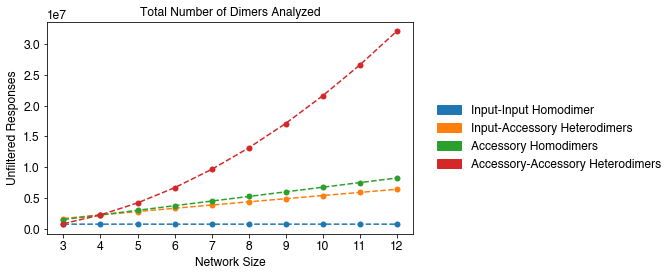

In [ ]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('tab10')

for species_type_i in range(4):
    ax.plot(m_list,num_unfiltered_curves_by_species_type_by_m[species_type_i],\
                marker='.',linestyle='--',markersize=12,markeredgewidth=0,color=cmap(species_type_i),alpha=1)

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Unfiltered Responses')
_ = ax.set_title(f'Total Number of Dimers Analyzed')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(x) for x in m_list])

patches={}
patches['input_input_homodimer'] = mpatches.Patch(color=cmap(0),label=f'Input-Input Homodimer')
patches['input_acc_heterodimers'] = mpatches.Patch(color=cmap(1),label=f'Input-Accessory Heterodimers')
patches['acc_acc_homodimers'] = mpatches.Patch(color=cmap(2),label=f'Accessory Homodimers')
patches['acc_acc_heterodimers'] = mpatches.Patch(color=cmap(3),label=f'Accessory-Accessory Heterodimers')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'num_unfiltered_curves_by_species_type'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

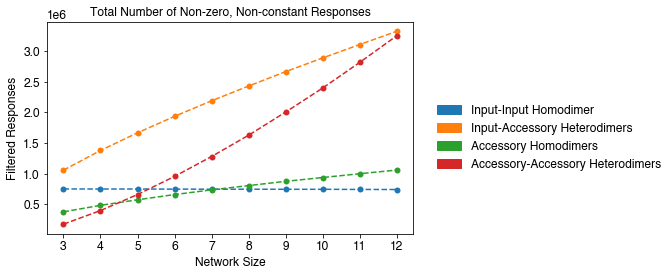

In [ ]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('tab10')

for species_type_i in range(4):
    ax.plot(m_list,num_filtered_curves_by_species_type_by_m[species_type_i],\
                marker='.',linestyle='--',markersize=12,markeredgewidth=0,color=cmap(species_type_i),alpha=1)

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Filtered Responses')
_ = ax.set_title(f'Total Number of Non-zero, Non-constant Responses')
_ = ax.set_xticks(m_list)
_ = ax.set_xticklabels([str(x) for x in m_list])

patches={}
patches['input_input_homodimer'] = mpatches.Patch(color=cmap(0),label=f'Input-Input Homodimer')
patches['input_acc_heterodimers'] = mpatches.Patch(color=cmap(1),label=f'Input-Accessory Heterodimers')
patches['acc_acc_homodimers'] = mpatches.Patch(color=cmap(2),label=f'Accessory Homodimers')
patches['acc_acc_heterodimers'] = mpatches.Patch(color=cmap(3),label=f'Accessory-Accessory Heterodimers')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'num_filtered_curves_by_species_type'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

And, for each network size, plot overlaps in the unique functions different species types can compute

Working on m=3
Working on m=4
Working on m=5
Working on m=6
Working on m=7
Working on m=8
Working on m=9
Working on m=10
Working on m=11
Working on m=12


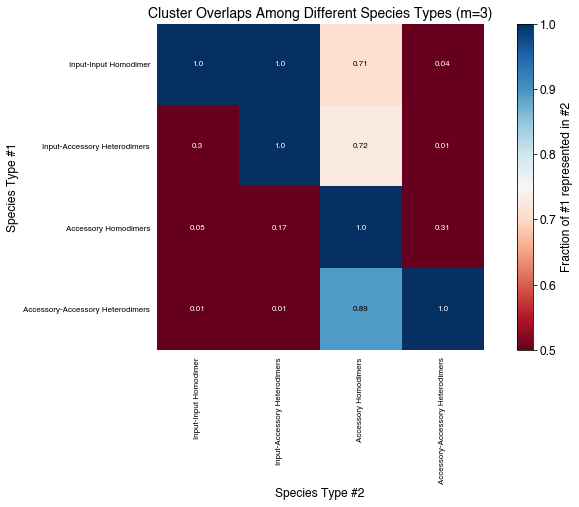

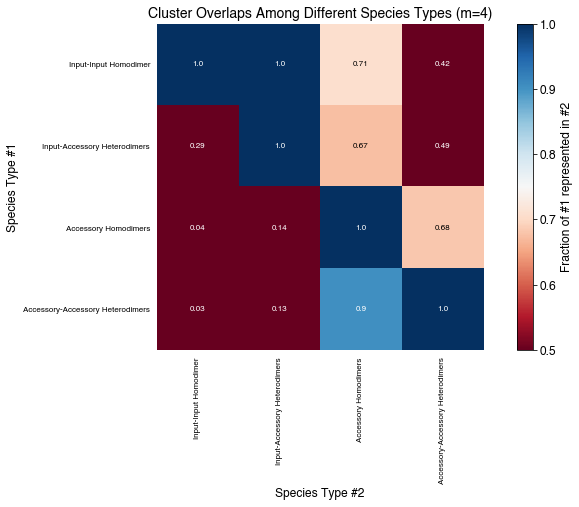

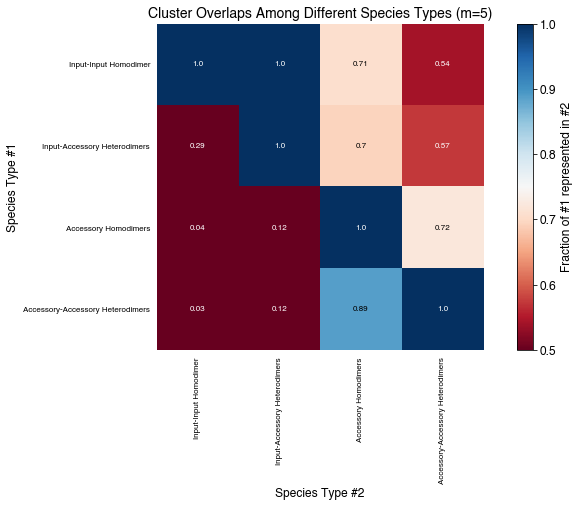

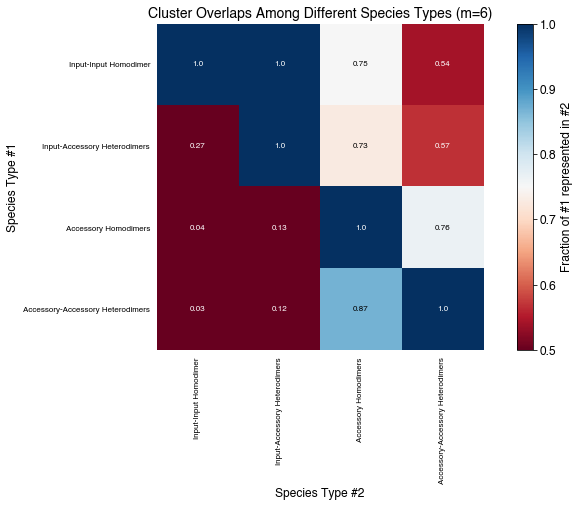

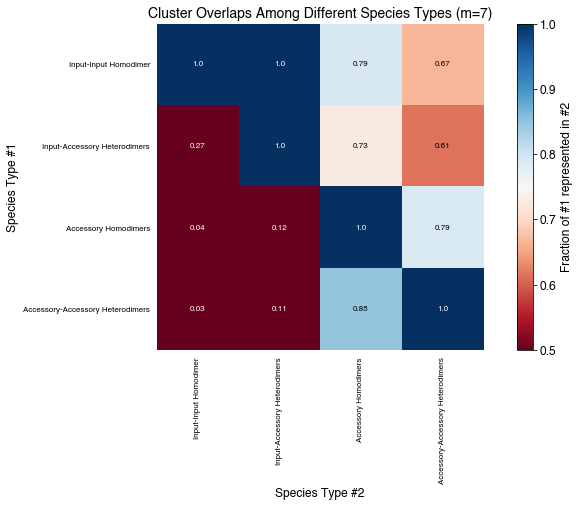

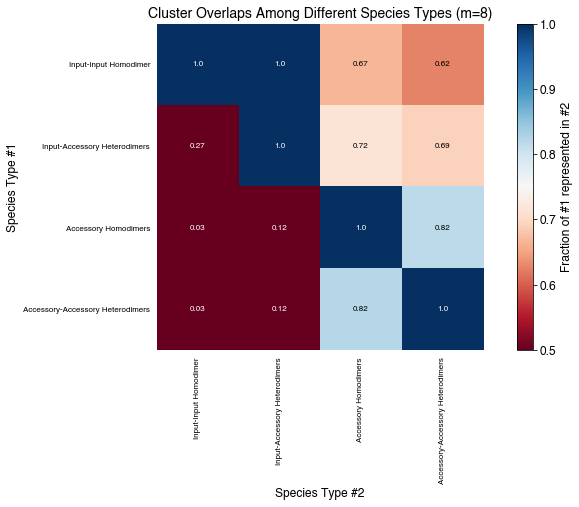

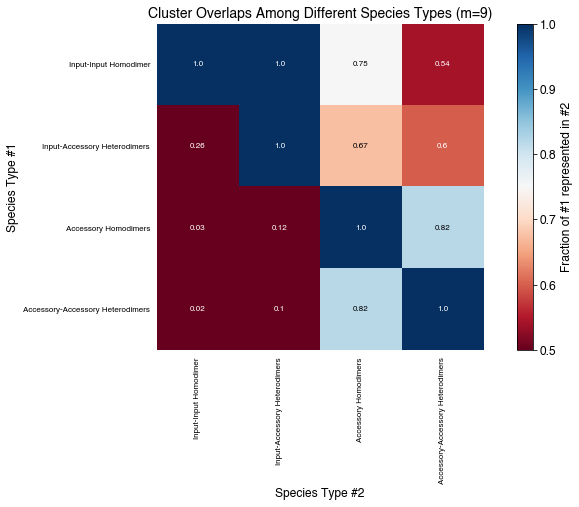

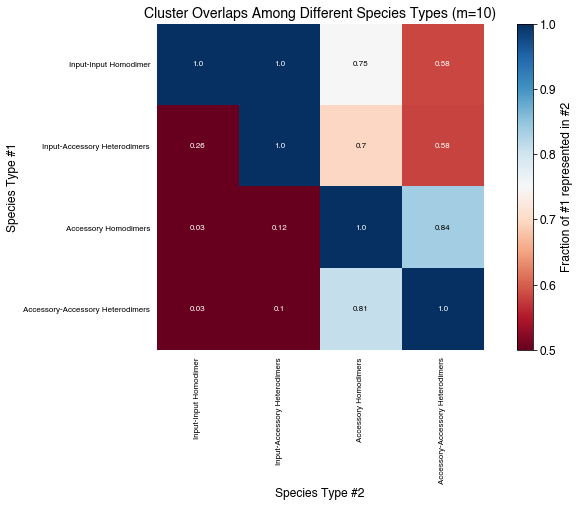

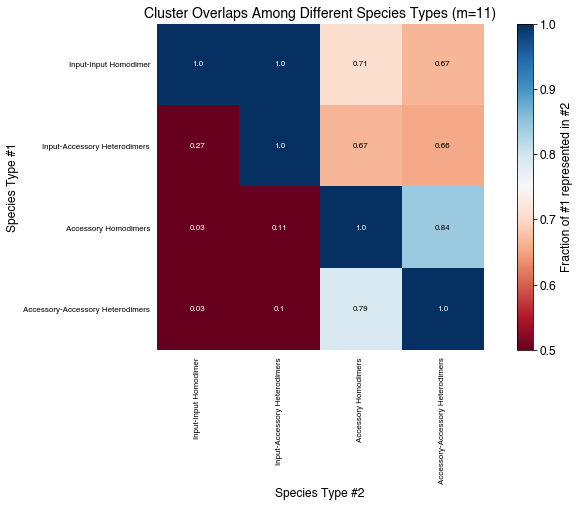

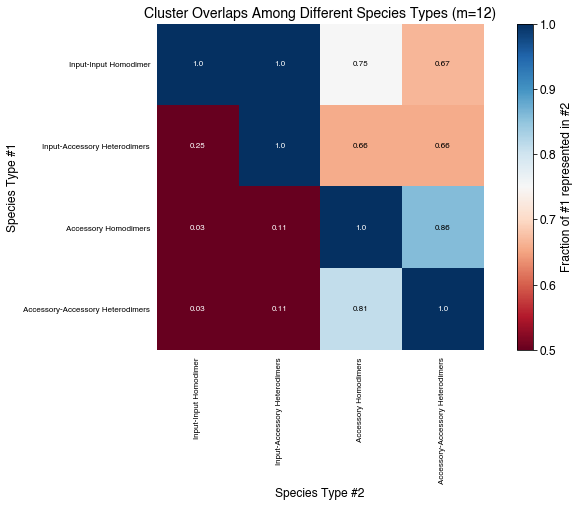

In [ ]:
for m_i, m in enumerate(m_list):
    print(f"Working on m={m}")
    voxel_overlaps = np.load(str(pathlib.Path(out_dir,f'{m}M_voxel_overlaps_by_species_type.npy')),allow_pickle=True)
    voxel_overlap_fractions = np.load(str(pathlib.Path(out_dir,f'{m}M_voxel_overlap_fractions_by_species_type.npy')),allow_pickle=True)
    fig, ax = plt.subplots(figsize=(12,6))

    cmap = cm.get_cmap('RdBu').copy()

    vmin = 0.5
    vmax = 1
    matrix = ax.matshow(voxel_overlap_fractions,cmap = cmap,vmin=vmin,vmax=vmax)

    for (j,i),label in np.ndenumerate(voxel_overlap_fractions):
        if label>(vmin+(0.2*(vmax-vmin))) and label<(vmin+(0.8*(vmax-vmin))):
            color='black'
        else:
            color='white'
        ax.text(i,j,round(label,2),ha='center',va='center',fontsize=8,color=color)

    spacer = ' '*10
    labels = ['Input-Input Homodimer','Input-Accessory Heterodimers','Accessory Homodimers','Accessory-Accessory Heterodimers']

    ax.set_xticks(list(range(4)))
    ax.set_xticklabels(labels,fontsize=8,rotation=90)
    ax.xaxis.set_ticks_position("bottom")

    ax.set_yticks(list(range(4)))
    ax.set_yticklabels(labels,fontsize=8)

    plt.tick_params(
        axis='both',          
        which='both',      
        bottom=False,      
        top=False,         
        right=False,
        left=False
     )
    ax.spines.right.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.spines.top.set_visible(False)

    fig.colorbar(matrix, ax=ax,label='Fraction of #1 represented in #2')

    _ = ax.set_xlabel('Species Type #2')
    _ = ax.set_ylabel('Species Type #1')
    _ = ax.set_title(f'Cluster Overlaps Among Different Species Types (m={m})',fontsize=14)
    
    filename = f'{m}M_voxel_overlaps_by_species_type'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

### Number of Unique Functions by Network Connectivity - Figure 4, S3

In [ ]:
load_dir = '/home/ubuntu/Data/20221108_1input_randomParamset'

In [ ]:
m_list = list(range(2,13))

In [ ]:
# Load, if necessary
S_all_filenames_by_m = np.load(str(pathlib.Path(load_dir,'S_all_filenames_by_m.npy')),allow_pickle=True)
all_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'all_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
unfiltered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'unfiltered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
nonzero_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'nonzero_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
filtered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'filtered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)

In [ ]:
min_affinity = 1e-5 # Affinity cutoff to be counted as an "edge"

# Function to count the number of edges in a parameter set
def count_edges(param_set):
    return np.where(param_set>=min_affinity)[0].shape[0]

In [ ]:
# Different network connectivities were sampled evenly within each network size, but across network sizes they were sampled differently
# This is because each network size got 1 million networks - while m=3 only has two connectivity levels, m=12 has many more, and each gets fewer networks
# So we just have to find the minimum and will bootstrap this number of networks
num_sets_per_num_edges_by_m = []
for m_i,m in enumerate(m_list):
    print(f"Processing m={m}")
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M',f'K_A_param_sets.npy')),allow_pickle=True)
    max_hetero_edges = num_combos(m,r=2)
    min_hetero_edges = m-1
    num_possible_num_edges = max_hetero_edges-min_hetero_edges+1 # number of possible connectivity values
    num_sets_per_num_edges = math.ceil(param_sets.shape[0]/num_possible_num_edges) # How many parameter sets were simulated for each connectivity value
    num_sets_per_num_edges_by_m.append(num_sets_per_num_edges)
np.save(str(pathlib.Path(out_dir,f'num_sets_per_num_edges_by_m.npy')),num_sets_per_num_edges_by_m)

In [ ]:
num_sets_per_num_edges_by_m = np.load(str(pathlib.Path(out_dir,f'num_sets_per_num_edges_by_m.npy')),allow_pickle=True)

In [ ]:
# Calculate number of networks to bootstrap from each network size to ensure comparable number of networks per network size & connectivity
min_sets_per_num_edges = np.min(num_sets_per_num_edges_by_m)
num_bootstrap_samples = 5
rng = np.random.default_rng()

In [ ]:
for m_i,m in enumerate(m_list):
    print(f"Processing m={m}")
    max_hetero_edges = num_combos(m,r=2)
    num_possible_homo_edges = m
    min_hetero_edges = m-1
    num_S_all_chunks = len(filtered_curves_per_Sall_chunk_by_m[m_i])
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M',f'K_A_param_sets.npy')),allow_pickle=True)
    unique_voxels = np.load(str(pathlib.Path(out_dir,f'{m}M_unique_voxels.npy')),allow_pickle=True)
    curves_by_voxel = np.load(str(pathlib.Path(out_dir,f'{m}M_curves_by_voxel.npy')),allow_pickle=True)
    dimers_by_param_set = np.load(str(pathlib.Path(out_dir,f'{m}M_dimers_by_param_set.npy')),allow_pickle=True)
    
    # Calculate unique_inverse, which maps each curve to its voxel
    unique_inverse = np.empty((np.sum(filtered_curves_per_Sall_chunk_by_m[m_i]),),dtype=np.int64)
    for voxel in range(curves_by_voxel.shape[0]):
        unique_inverse[curves_by_voxel[voxel]] = voxel
    
    # Compute types of edges (heterodimer, homodimer)
    homo_edges = []
    hetero_edges = []

    for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
        if combo[0]==combo[1]:
            homo_edges.append(i)
        else:
            hetero_edges.append(i)

    # Calculate how many heterodimer edges each parameter set has
    hetero_edges_by_param_set = np.apply_along_axis(count_edges, 1, param_sets[:,hetero_edges])
    hetero_edges_list = list(range(min_hetero_edges,max_hetero_edges+1))
    
    num_unique_voxels_by_hetero_edges = [[] for num_hetero_edges in hetero_edges_list]
    redundancy_by_hetero_edges = [[] for num_hetero_edges in hetero_edges_list]
    unfiltered_curves_by_hetero_edges = [[] for num_hetero_edges in hetero_edges_list]
    filtered_curves_by_hetero_edges = [[] for num_hetero_edges in hetero_edges_list]

    fraction_passed_filter_by_hetero_edges = []
    total_unfiltered_curves_by_hetero_edges = []
    total_filtered_curves_by_hetero_edges = []
    
    # If we are analyzing the largest network, we need only bootstrap once because we are using the full dataset
    if m == m_list[-1]:
        num_bootstrap_samples_temp = 1
    else:
        num_bootstrap_samples_temp = num_bootstrap_samples
    
    # Iterate over number of heterodimer edges
    for num_hetero_edges_i,num_hetero_edges in enumerate(hetero_edges_list):
        # Identify parameter sets with this number of heterodimer edges
        param_set_idx_with_num_edges = np.where(hetero_edges_by_param_set==num_hetero_edges)[0]
        # To sample evenly, we will then bootstrap from this list of parameter sets
        for bootstrap_i in range(num_bootstrap_samples_temp):
            # Randomly bootstrap from the list of parameter sets with this number of heterodimer edges
            param_set_idx_with_num_edges_bootstrap = rng.choice(param_set_idx_with_num_edges,size=(min_sets_per_num_edges,),replace=False)
            curve_idx_with_num_edges = np.array(list(itertools.chain.from_iterable([list(range(param_set_id*(num_combos_with_replacement(m,r=2)),\
                        (param_set_id+1)*(num_combos_with_replacement(m,r=2)))) for param_set_id in param_set_idx_with_num_edges_bootstrap]))) # Unfiltered IDs
            num_unfiltered_ids = np.sum(dimers_by_param_set.reshape((-1,))[curve_idx_with_num_edges])
            num_filtered_ids = 0
            unique_voxel_ids = np.empty((0,))
            # Iterate over chunks of S_all (the responses), which were saved across several files
            for S_all_chunk in range(num_S_all_chunks):
                # Identify curves in this S_all chunk with this number of heterodimer edges
                curve_idx_with_num_edges_in_chunk = curve_idx_with_num_edges[np.where((curve_idx_with_num_edges>=np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk]))\
                                                 & (curve_idx_with_num_edges<np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk+1])))] # Unfiltered IDs
                if curve_idx_with_num_edges_in_chunk.shape[0]==0:
                    continue
                curve_idx_with_num_edges_in_chunk = (curve_idx_with_num_edges_in_chunk-\
                                            np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64) # Unfiltered IDs, starting at 0 within chunk
                # S_all_processed_filtered = np.load(str(pathlib.Path(load_dir,f'{m}M',f'S_all_processed_filtered_{S_all_chunk}.npy')),allow_pickle=True)
                univ_filter_map_filename = str(pathlib.Path(load_dir,f'{m}M',f'univ_filter_map_{S_all_chunk}.npy'))
                univ_filter_map = np.load(str(pathlib.Path(load_dir,f'{m}M',univ_filter_map_filename)),allow_pickle=True)
                curve_idx_with_num_edges_passed_filter = \
                    curve_idx_with_num_edges_in_chunk[np.isin(curve_idx_with_num_edges_in_chunk,univ_filter_map[:,0])] # Unfiltered IDs, starting at 0 within chunk, that passed filtering
                curve_idx_with_num_edges_filtered = univ_filter_map[np.isin(univ_filter_map[:,0],curve_idx_with_num_edges_passed_filter)][:,1] # Filtered IDs, starting at 0 within chunk
                num_filtered_ids += curve_idx_with_num_edges_filtered.shape[0]
                # S_all_subset = S_all_processed_filtered[curve_idx_with_num_edges_filtered,:]
                # Knowing which curves are in this chunk, and the voxels for each curve, we can identify the unique voxels of this subset
                if unique_voxel_ids.shape[0]==0:
                    # If this is the first chunk with curves of num_hetero_edges, we need to initialize unique_voxel_ids
                    unique_voxel_ids = np.unique(unique_inverse[(curve_idx_with_num_edges_filtered+\
                                                                 np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64)])
                else:
                    # Otherwise, append to unique_voxel_ids
                    unique_voxel_ids_temp = np.unique(unique_inverse[(curve_idx_with_num_edges_filtered+\
                                                                 np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64)])
                    unique_voxel_ids = np.unique(np.concatenate((unique_voxel_ids,unique_voxel_ids_temp),\
                                                             axis=0),axis=0,return_inverse=False)
            num_unique_voxels_by_hetero_edges[num_hetero_edges_i].append(unique_voxel_ids.shape[0])
            redundancy_by_hetero_edges[num_hetero_edges_i].append(num_filtered_ids/unique_voxel_ids.shape[0])
            unfiltered_curves_by_hetero_edges[num_hetero_edges_i].append(num_unfiltered_ids)
            filtered_curves_by_hetero_edges[num_hetero_edges_i].append(num_filtered_ids)
        
        # For the other metrics (fraction of curves to pass filter), we will use the full dataset (no bootstrapping)
        curve_idx_with_num_edges = np.array(list(itertools.chain.from_iterable([list(range(param_set_id*(num_combos_with_replacement(m,r=2)),\
                    (param_set_id+1)*(num_combos_with_replacement(m,r=2)))) for param_set_id in param_set_idx_with_num_edges]))) # Unfiltered IDs
        num_unfiltered_ids = np.sum(dimers_by_param_set.reshape((-1,))[curve_idx_with_num_edges])
        num_filtered_ids = 0
        # Iterate over chunks of S_all (the responses), which were saved across several files
        for S_all_chunk in range(num_S_all_chunks):
            curve_idx_with_num_edges_in_chunk = curve_idx_with_num_edges[np.where((curve_idx_with_num_edges>=np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk]))\
                                             & (curve_idx_with_num_edges<np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk+1])))] # Unfiltered IDs
            if curve_idx_with_num_edges_in_chunk.shape[0]==0:
                continue
            curve_idx_with_num_edges_in_chunk = (curve_idx_with_num_edges_in_chunk-\
                                        np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64) # Unfiltered IDs, starting at 0 within chunk
            # S_all_processed_filtered = np.load(str(pathlib.Path(load_dir,f'{m}M',f'S_all_processed_filtered_{S_all_chunk}.npy')),allow_pickle=True)
            univ_filter_map_filename = str(pathlib.Path(load_dir,f'{m}M',f'univ_filter_map_{S_all_chunk}.npy'))
            univ_filter_map = np.load(str(pathlib.Path(load_dir,f'{m}M',univ_filter_map_filename)),allow_pickle=True)
            curve_idx_with_num_edges_passed_filter = \
                curve_idx_with_num_edges_in_chunk[np.isin(curve_idx_with_num_edges_in_chunk,univ_filter_map[:,0])] # Unfiltered IDs, starting at 0 within chunk, that passed filtering
            curve_idx_with_num_edges_filtered = univ_filter_map[np.isin(univ_filter_map[:,0],curve_idx_with_num_edges_passed_filter)][:,1] # Filtered IDs, starting at 0 within chunk
            num_filtered_ids += curve_idx_with_num_edges_filtered.shape[0]
        fraction_passed_filter_by_hetero_edges.append(num_filtered_ids/num_unfiltered_ids)
        total_unfiltered_curves_by_hetero_edges.append(num_unfiltered_ids)
        total_filtered_curves_by_hetero_edges.append(num_filtered_ids)
    
    np.save(str(pathlib.Path(out_dir,f'{m}M_hetero_edges_list.npy')),hetero_edges_list)
    np.save(str(pathlib.Path(out_dir,f'{m}M_num_unique_voxels_by_hetero_edges.npy')),num_unique_voxels_by_hetero_edges)
    np.save(str(pathlib.Path(out_dir,f'{m}M_redundancy_by_hetero_edges.npy')),redundancy_by_hetero_edges)
    np.save(str(pathlib.Path(out_dir,f'{m}M_fraction_passed_filter_by_hetero_edges.npy')),fraction_passed_filter_by_hetero_edges)
    np.save(str(pathlib.Path(out_dir,f'{m}M_unfiltered_curves_by_hetero_edges.npy')),unfiltered_curves_by_hetero_edges)
    np.save(str(pathlib.Path(out_dir,f'{m}M_filtered_curves_by_hetero_edges.npy')),filtered_curves_by_hetero_edges)
    np.save(str(pathlib.Path(out_dir,f'{m}M_total_unfiltered_curves_by_hetero_edges.npy')),total_unfiltered_curves_by_hetero_edges)
    np.save(str(pathlib.Path(out_dir,f'{m}M_total_filtered_curves_by_hetero_edges.npy')),total_filtered_curves_by_hetero_edges)

Processing m=3
Processing m=4
Processing m=5
Processing m=6
Processing m=7
Processing m=8
Processing m=9
Processing m=10
Processing m=11
Processing m=12


Plot:

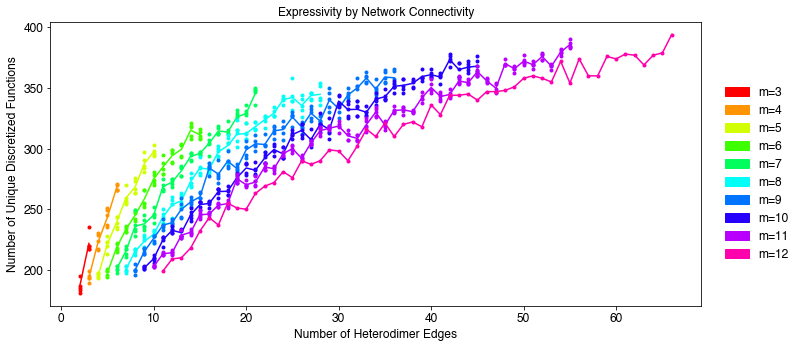

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = cm.get_cmap('hsv')

for m_i,m in enumerate(m_list):
    hetero_edges_list = np.load(str(pathlib.Path(out_dir,f'{m}M_hetero_edges_list.npy')),allow_pickle=True)
    num_unique_voxels_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_num_unique_voxels_by_hetero_edges.npy')),allow_pickle=True)
    if m == m_list[-1]:
        num_bootstrap_samples_temp = 1
    else:
        num_bootstrap_samples_temp = num_bootstrap_samples
    x_vals = list(itertools.chain.from_iterable([[x for i in range(num_bootstrap_samples_temp)] for x in hetero_edges_list]))
    y_val_means = [np.mean(x) for x in num_unique_voxels_by_hetero_edges]
    ax.plot(x_vals,list(itertools.chain.from_iterable(num_unique_voxels_by_hetero_edges)),\
            marker='.',linestyle='',markersize=8,markeredgewidth=0,color=cmap(m_i/(len(m_list))),alpha=1)
    ax.plot(hetero_edges_list,y_val_means,\
            marker='',linestyle='-',color=cmap(m_i/(len(m_list))),alpha=1)

_ = ax.set_xlabel('Number of Heterodimer Edges')
_ = ax.set_ylabel('Number of Unique Discretized Functions')
_ = ax.set_title(f'Expressivity by Network Connectivity')

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'num_unique_voxels_by_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

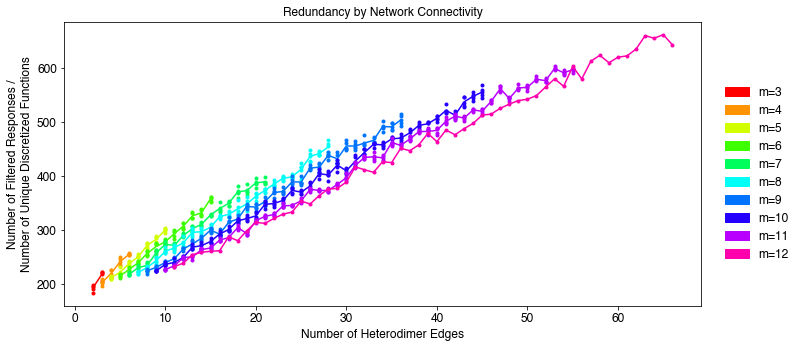

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = cm.get_cmap('hsv')

for m_i,m in enumerate(m_list):
    hetero_edges_list = np.load(str(pathlib.Path(out_dir,f'{m}M_hetero_edges_list.npy')),allow_pickle=True)
    redundancy_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_redundancy_by_hetero_edges.npy')),allow_pickle=True)
    if m == m_list[-1]:
        num_bootstrap_samples_temp = 1
    else:
        num_bootstrap_samples_temp = num_bootstrap_samples
    x_vals = list(itertools.chain.from_iterable([[x for i in range(num_bootstrap_samples_temp)] for x in hetero_edges_list]))
    y_val_means = [np.mean(x) for x in redundancy_by_hetero_edges]
    ax.plot(x_vals,list(itertools.chain.from_iterable(redundancy_by_hetero_edges)),\
            marker='.',linestyle='',markersize=8,markeredgewidth=0,color=cmap(m_i/(len(m_list))),alpha=1)
    ax.plot(hetero_edges_list,y_val_means,\
            marker='',linestyle='-',color=cmap(m_i/(len(m_list))),alpha=1)

_ = ax.set_xlabel('Number of Heterodimer Edges')
_ = ax.set_ylabel('Number of Filtered Responses /\nNumber of Unique Discretized Functions')
_ = ax.set_title(f'Redundancy by Network Connectivity')

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'redundancy_by_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

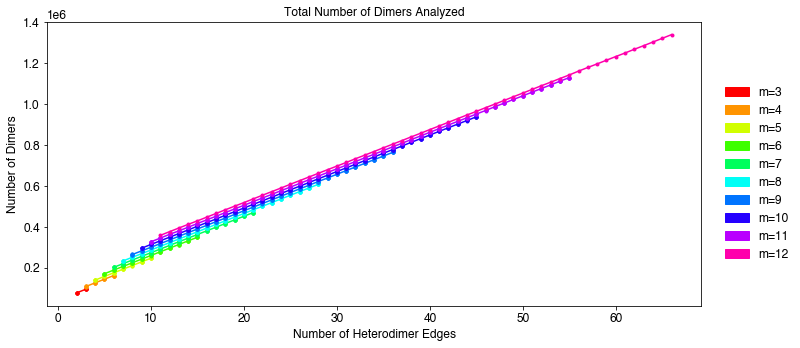

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = cm.get_cmap('hsv')

for m_i,m in enumerate(m_list):
    hetero_edges_list = np.load(str(pathlib.Path(out_dir,f'{m}M_hetero_edges_list.npy')),allow_pickle=True)
    num_unfiltered_curves_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_unfiltered_curves_by_hetero_edges.npy')),allow_pickle=True)
    if m == m_list[-1]:
        num_bootstrap_samples_temp = 1
    else:
        num_bootstrap_samples_temp = num_bootstrap_samples
    x_vals = list(itertools.chain.from_iterable([[x for i in range(num_bootstrap_samples_temp)] for x in hetero_edges_list]))
    y_val_means = [np.mean(x) for x in num_unfiltered_curves_by_hetero_edges]
    ax.plot(x_vals,list(itertools.chain.from_iterable(num_unfiltered_curves_by_hetero_edges)),\
            marker='.',linestyle='',markersize=8,markeredgewidth=0,color=cmap(m_i/(len(m_list))),alpha=1)
    ax.plot(hetero_edges_list,y_val_means,\
            marker='',linestyle='-',color=cmap(m_i/(len(m_list))),alpha=1)

_ = ax.set_xlabel('Number of Heterodimer Edges')
_ = ax.set_ylabel('Number of Dimers')
_ = ax.set_title(f'Total Number of Dimers Analyzed')

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'num_unfiltered_curves_by_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

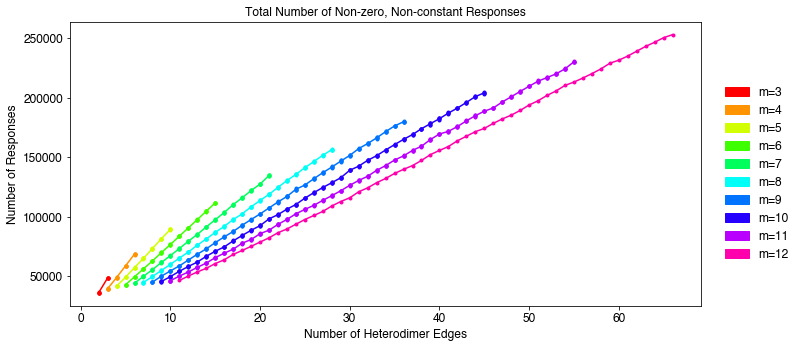

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = cm.get_cmap('hsv')

for m_i,m in enumerate(m_list):
    hetero_edges_list = np.load(str(pathlib.Path(out_dir,f'{m}M_hetero_edges_list.npy')),allow_pickle=True)
    num_filtered_curves_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_filtered_curves_by_hetero_edges.npy')),allow_pickle=True)
    if m == m_list[-1]:
        num_bootstrap_samples_temp = 1
    else:
        num_bootstrap_samples_temp = num_bootstrap_samples
    x_vals = list(itertools.chain.from_iterable([[x for i in range(num_bootstrap_samples_temp)] for x in hetero_edges_list]))
    y_val_means = [np.mean(x) for x in num_filtered_curves_by_hetero_edges]
    ax.plot(x_vals,list(itertools.chain.from_iterable(num_filtered_curves_by_hetero_edges)),\
            marker='.',linestyle='',markersize=8,markeredgewidth=0,color=cmap(m_i/(len(m_list))),alpha=1)
    ax.plot(hetero_edges_list,y_val_means,\
            marker='',linestyle='-',color=cmap(m_i/(len(m_list))),alpha=1)

_ = ax.set_xlabel('Number of Heterodimer Edges')
_ = ax.set_ylabel('Number of Responses')
_ = ax.set_title(f'Total Number of Non-zero, Non-constant Responses')

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'num_filtered_curves_by_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

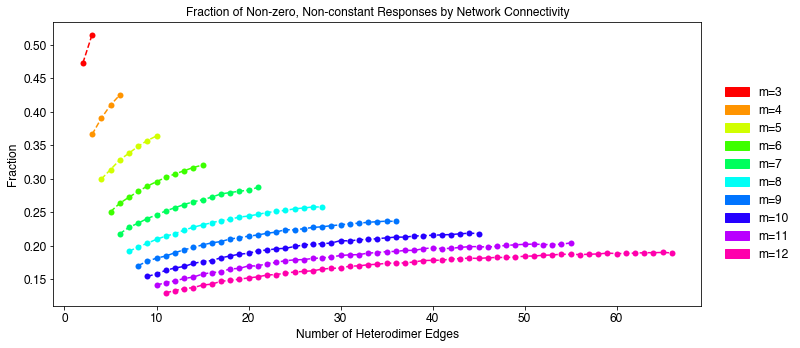

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = cm.get_cmap('hsv')

for m_i,m in enumerate(m_list):
    hetero_edges_list = np.load(str(pathlib.Path(out_dir,f'{m}M_hetero_edges_list.npy')),allow_pickle=True)
    fraction_passed_filter_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_fraction_passed_filter_by_hetero_edges.npy')),allow_pickle=True)
    ax.plot(hetero_edges_list,fraction_passed_filter_by_hetero_edges,\
            marker='.',linestyle='--',markersize=12,markeredgewidth=0,color=cmap(m_i/(len(m_list))),alpha=1)

_ = ax.set_xlabel('Number of Heterodimer Edges')
_ = ax.set_ylabel('Fraction')
_ = ax.set_title('Fraction of Non-zero, Non-constant Responses by Network Connectivity')

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'fraction_passed_filter_by_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

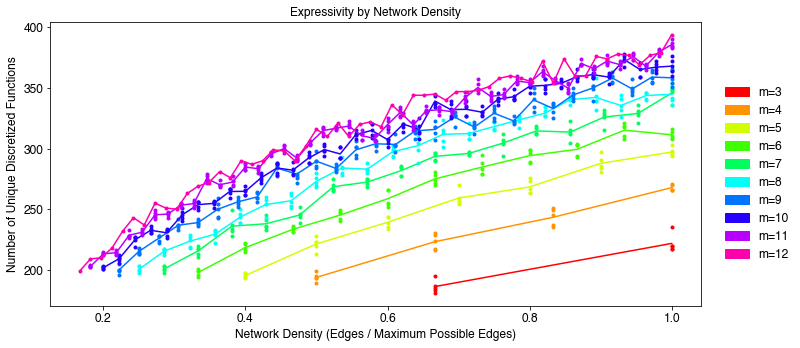

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = cm.get_cmap('hsv')

for m_i,m in enumerate(m_list):
    hetero_edges_list = np.load(str(pathlib.Path(out_dir,f'{m}M_hetero_edges_list.npy')),allow_pickle=True)
    num_unique_voxels_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_num_unique_voxels_by_hetero_edges.npy')),allow_pickle=True)
    max_hetero_edges = num_combos(m,r=2)
    min_hetero_edges = m-1
    graph_density = [x/(max_hetero_edges) \
                               for x in list(range(min_hetero_edges,max_hetero_edges+1))]
    if m == m_list[-1]:
        num_bootstrap_samples_temp = 1
    else:
        num_bootstrap_samples_temp = num_bootstrap_samples
    x_vals = list(itertools.chain.from_iterable([[x for i in range(num_bootstrap_samples_temp)] for x in graph_density]))
    y_val_means = [np.mean(x) for x in num_unique_voxels_by_hetero_edges]
    ax.plot(x_vals,list(itertools.chain.from_iterable(num_unique_voxels_by_hetero_edges)),\
            marker='.',linestyle='',markersize=8,markeredgewidth=0,color=cmap(m_i/(len(m_list))),alpha=1)
    ax.plot(graph_density,y_val_means,\
            marker='',linestyle='-',color=cmap(m_i/(len(m_list))),alpha=1)

_ = ax.set_xlabel('Network Density (Edges / Maximum Possible Edges)')
_ = ax.set_ylabel('Number of Unique Discretized Functions')
_ = ax.set_title(f'Expressivity by Network Density')

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'num_unique_voxels_by_fraction_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

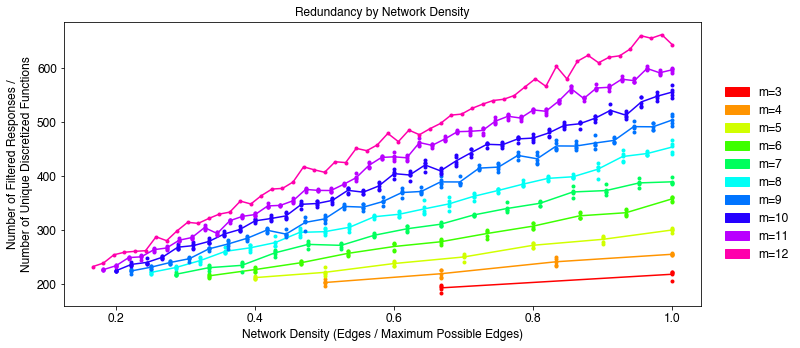

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = cm.get_cmap('hsv')

for m_i,m in enumerate(m_list):
    hetero_edges_list = np.load(str(pathlib.Path(out_dir,f'{m}M_hetero_edges_list.npy')),allow_pickle=True)
    redundancy_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_redundancy_by_hetero_edges.npy')),allow_pickle=True)
    max_hetero_edges = num_combos(m,r=2)
    min_hetero_edges = m-1
    graph_density = [x/(max_hetero_edges) \
                               for x in list(range(min_hetero_edges,max_hetero_edges+1))]
    if m == m_list[-1]:
        num_bootstrap_samples_temp = 1
    else:
        num_bootstrap_samples_temp = num_bootstrap_samples
    x_vals = list(itertools.chain.from_iterable([[x for i in range(num_bootstrap_samples_temp)] for x in graph_density]))
    y_val_means = [np.mean(x) for x in redundancy_by_hetero_edges]
    ax.plot(x_vals,list(itertools.chain.from_iterable(redundancy_by_hetero_edges)),\
            marker='.',linestyle='',markersize=8,markeredgewidth=0,color=cmap(m_i/(len(m_list))),alpha=1)
    ax.plot(graph_density,y_val_means,\
            marker='',linestyle='-',color=cmap(m_i/(len(m_list))),alpha=1)

_ = ax.set_xlabel('Network Density (Edges / Maximum Possible Edges)')
_ = ax.set_ylabel('Number of Filtered Responses /\nNumber of Unique Discretized Functions')
_ = ax.set_title(f'Redundancy by Network Density')

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'redundancy_by_fraction_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

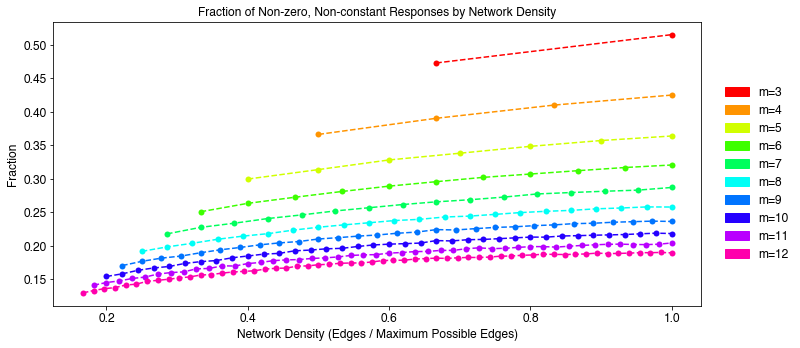

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = cm.get_cmap('hsv')

for m_i,m in enumerate(m_list):
    hetero_edges_list = np.load(str(pathlib.Path(out_dir,f'{m}M_hetero_edges_list.npy')),allow_pickle=True)
    fraction_passed_filter_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_fraction_passed_filter_by_hetero_edges.npy')),allow_pickle=True)
    max_hetero_edges = num_combos(m,r=2)
    min_hetero_edges = m -1
    graph_density = [x/(max_hetero_edges) \
                               for x in list(range(min_hetero_edges,max_hetero_edges+1))]
    ax.plot(graph_density,fraction_passed_filter_by_hetero_edges,\
            marker='.',linestyle='--',markersize=12,markeredgewidth=0,color=cmap(m_i/(len(m_list))),alpha=1)

_ = ax.set_xlabel('Network Density (Edges / Maximum Possible Edges)')
_ = ax.set_ylabel('Fraction')
_ = ax.set_title('Fraction of Non-zero, Non-constant Responses by Network Density')

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'fraction_passed_filter_by_fraction_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

#### Try plotting cumulatively, assuming more connected networks encompass less connected networks

In [ ]:
for m_i,m in enumerate(m_list):
    print(f"Processing m={m}")
    max_hetero_edges = num_combos(m,r=2)
    num_possible_homo_edges = m
    min_hetero_edges = m-1
    num_S_all_chunks = len(filtered_curves_per_Sall_chunk_by_m[m_i])
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M_{load_dir_i}',f'K_A_param_sets.npy')),allow_pickle=True)
    unique_voxels = np.load(str(pathlib.Path(out_dir,f'{m}M_unique_voxels.npy')),allow_pickle=True)
    curves_by_voxel = np.load(str(pathlib.Path(out_dir,f'{m}M_curves_by_voxel.npy')),allow_pickle=True)
    dimers_by_param_set = np.load(str(pathlib.Path(out_dir,f'{m}M_dimers_by_param_set.npy')),allow_pickle=True)
    
    unique_inverse = np.empty((np.sum(filtered_curves_per_Sall_chunk_by_m[m_i]),),dtype=np.int64)
    for voxel in range(curves_by_voxel.shape[0]):
        unique_inverse[curves_by_voxel[voxel]] = voxel
    
    homo_edges = []
    hetero_edges = []

    for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
        if combo[0]==combo[1]:
            homo_edges.append(i)
        else:
            hetero_edges.append(i)
    all_edges = homo_edges+hetero_edges

    hetero_edges_by_param_set = np.apply_along_axis(count_edges, 1, param_sets[:,hetero_edges])
    homo_edges_by_param_set = np.apply_along_axis(count_edges, 1, param_sets[:,homo_edges])
    total_edges_by_param_set = np.apply_along_axis(count_edges, 1, param_sets[:,all_edges])
    hetero_edges_list = list(range(min_hetero_edges,max_hetero_edges+1))
    homo_edges_list = list(range(m+1))
    total_edges_list = list(range(min_hetero_edges,max_hetero_edges+m+1))
        
    num_unique_voxels_by_hetero_edges = [[] for num_hetero_edges in hetero_edges_list]
    redundancy_by_hetero_edges = [[] for num_hetero_edges in hetero_edges_list]
    unfiltered_curves_by_hetero_edges = [[] for num_hetero_edges in hetero_edges_list]
    filtered_curves_by_hetero_edges = [[] for num_hetero_edges in hetero_edges_list]
    # num_unique_voxels_by_homo_edges = []
    # num_unique_voxels_by_total_edges = []
    fraction_passed_filter_by_hetero_edges = []
    total_unfiltered_curves_by_hetero_edges = []
    total_filtered_curves_by_hetero_edges = []
    
    unique_voxel_ids_previous = np.array([]) # Will be updated each iteration
    
    for num_hetero_edges_i,num_hetero_edges in enumerate(progressbar.progressbar(hetero_edges_list)):
        param_set_idx_with_num_edges = np.where(hetero_edges_by_param_set==num_hetero_edges)[0]
        # For the other metrics, we will use the full dataset
        curve_idx_with_num_edges = np.array(list(itertools.chain.from_iterable([list(range(param_set_id*(num_combos_with_replacement(m,r=2)),\
                    (param_set_id+1)*(num_combos_with_replacement(m,r=2)))) for param_set_id in param_set_idx_with_num_edges]))) # Unfiltered IDs
        unique_voxel_ids = np.empty((0,))
        for S_all_chunk in range(num_S_all_chunks):
            curve_idx_with_num_edges_in_chunk = curve_idx_with_num_edges[np.where((curve_idx_with_num_edges>=np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk]))\
                                             & (curve_idx_with_num_edges<np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk+1])))] # Unfiltered IDs
            if curve_idx_with_num_edges_in_chunk.shape[0]==0:
                continue
            curve_idx_with_num_edges_in_chunk = (curve_idx_with_num_edges_in_chunk-\
                                        np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64) # Unfiltered IDs, starting at 0 within chunk
            # S_all_processed_filtered = np.load(str(pathlib.Path(load_dir,f'{m}M_{load_dir_i}',f'S_all_processed_filtered_{S_all_chunk}.npy')),allow_pickle=True)
            univ_filter_map_filename = str(pathlib.Path(load_dir,f'{m}M_{load_dir_i}',f'univ_filter_map_{S_all_chunk}.npy'))
            univ_filter_map = np.load(str(pathlib.Path(load_dir,f'{m}M_{load_dir_i}',univ_filter_map_filename)),allow_pickle=True)
            curve_idx_with_num_edges_passed_filter = \
                curve_idx_with_num_edges_in_chunk[np.isin(curve_idx_with_num_edges_in_chunk,univ_filter_map[:,0])] # Unfiltered IDs, starting at 0 within chunk, that passed filtering
            curve_idx_with_num_edges_filtered = univ_filter_map[np.isin(univ_filter_map[:,0],curve_idx_with_num_edges_passed_filter)][:,1] # Filtered IDs, starting at 0 within chunk
            if unique_voxel_ids.shape[0]==0:
                unique_voxel_ids = np.unique(unique_inverse[(curve_idx_with_num_edges_filtered+\
                                                             np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64)])
            else:
                unique_voxel_ids_temp = np.unique(unique_inverse[(curve_idx_with_num_edges_filtered+\
                                                             np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64)])
                unique_voxel_ids = np.unique(np.concatenate((unique_voxel_ids,unique_voxel_ids_temp),\
                                                         axis=0),axis=0,return_inverse=False)
        unique_voxel_ids_previous = np.unique(np.hstack((unique_voxel_ids_previous,unique_voxel_ids)))
        num_unique_voxels_by_hetero_edges[num_hetero_edges_i].append(unique_voxel_ids_previous.shape[0])
    
    np.save(str(pathlib.Path(out_dir,f'{m}M_num_cumulative_unique_voxels_by_hetero_edges.npy')),num_unique_voxels_by_hetero_edges)

Processing m=2


100% (1 of 1) |##########################| Elapsed Time: 0:00:03 Time:  0:00:03


Processing m=3


100% (2 of 2) |##########################| Elapsed Time: 0:00:03 Time:  0:00:03


Processing m=4


100% (4 of 4) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05


Processing m=5


100% (7 of 7) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06


Processing m=6


100% (11 of 11) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


Processing m=7


100% (16 of 16) |########################| Elapsed Time: 0:00:09 Time:  0:00:09


Processing m=8


100% (22 of 22) |########################| Elapsed Time: 0:00:11 Time:  0:00:11


Processing m=9


100% (29 of 29) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Processing m=10


100% (37 of 37) |########################| Elapsed Time: 0:00:16 Time:  0:00:16


Processing m=11


100% (46 of 46) |########################| Elapsed Time: 0:00:20 Time:  0:00:20


Processing m=12


100% (56 of 56) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


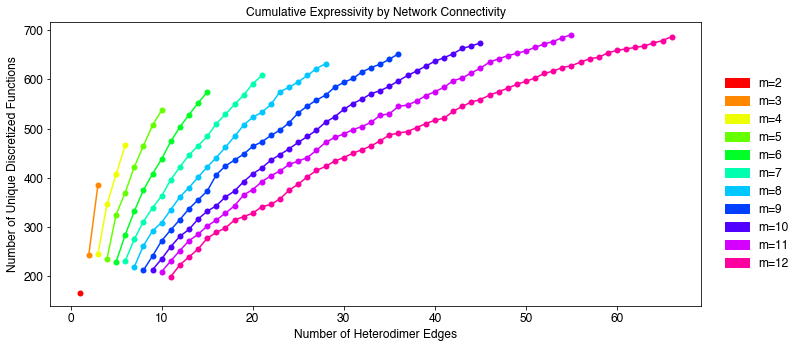

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = cm.get_cmap('hsv')

for m_i,m in enumerate(m_list):
    hetero_edges_list = np.load(str(pathlib.Path(out_dir,f'{m}M_hetero_edges_list.npy')),allow_pickle=True)
    num_unique_voxels_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_num_cumulative_unique_voxels_by_hetero_edges.npy')),allow_pickle=True)
    ax.plot(hetero_edges_list,num_unique_voxels_by_hetero_edges,\
            marker='.',linestyle='-',markersize=12,markeredgewidth=0,color=cmap(m_i/(len(m_list))),alpha=1)

_ = ax.set_xlabel('Number of Heterodimer Edges')
_ = ax.set_ylabel('Number of Unique Discretized Functions')
_ = ax.set_title(f'Cumulative Expressivity by Network Connectivity')

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'num_unique_cumulative_voxels_by_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Count 2-output functions

In [ ]:
# Define directory of the archived data folder parresgold_2023_dimer_networks_data
load_dir = str(pathlib.Path('E:\\parresgold_2023_dimer_networks','parresgold_2023_dimer_networks_data'))

In [ ]:
m_list = list(range(2,13)) # Network sizes to analyze

t = 30 # Number of input points to simulate
input_lb = -3 # Lower bound of input range in log scale
input_ub = 3 # Upper bound of input range in log scale

In [ ]:
# Load, if necessary
S_all_filenames_by_m = np.load(str(pathlib.Path(load_dir,'param_screen_1D','S_all_filenames_by_m.npy')),allow_pickle=True)
all_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'param_screen_1D','all_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
unfiltered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'param_screen_1D','unfiltered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
nonzero_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'param_screen_1D','nonzero_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
filtered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'param_screen_1D','filtered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)

In [ ]:
out_dir_temp = str(pathlib.Path(out_dir,'1input, 2output'))

In [ ]:
for m_i, m in enumerate(m_list):
    m_i = m_list.index(m)
    print(f"Working on m={m}")
    # Load info on dataset
    param_sets = np.load(str(pathlib.Path(load_dir,'param_screen_1D',f'{m}M',f'K_A_param_sets.npy')),allow_pickle=True)
    # unique_voxels = np.load(str(pathlib.Path(load_dir,'param_screen_analysis_1D',f'{m}M_unique_voxels.npy')),allow_pickle=True)
    curves_by_voxel = np.load(str(pathlib.Path(load_dir,'param_screen_analysis_1D',f'{m}M_curves_by_voxel.npy')),allow_pickle=True)
    
    # Create unique_inverse mapping from curves to voxels
    unique_inverse = np.empty((np.sum(filtered_curves_per_Sall_chunk_by_m[m_i]),),dtype=np.int64)
    for voxel in range(curves_by_voxel.shape[0]):
        unique_inverse[curves_by_voxel[voxel]] = voxel

    num_S_all_chunks = len(S_all_filenames_by_m[m_i])

    # Dataset info
    num_sets = param_sets.shape[0]
    dimers_per_network = num_combos_with_replacement(m,r=2)
    all_curve_idx = np.linspace(0,num_sets*dimers_per_network,num_sets*dimers_per_network,endpoint=False,dtype=np.int64) # Unfiltered IDs. Recall that monomers aren't in this dataset.

    unique_voxel_combos = np.empty((0,)) # Initialize dummy array
    unique_voxels_thism = np.empty((0,)) # Initialize dummy array

    combos_counted = 0
    skipped_networks = 0
    for S_all_chunk in range(num_S_all_chunks):
        print(f"Working on m={m}, chunk {S_all_chunk}")
        curve_idx_in_chunk = all_curve_idx[np.where((all_curve_idx>=np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk]))\
                                                & (all_curve_idx<np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk+1])))] # Unfiltered IDs in chunk
        if curve_idx_in_chunk.shape[0]==0:
            continue
        # S_all_processed_filtered = np.load(str(pathlib.Path(load_dir,'param_screen_1D',f'{m}M',f'S_all_processed_filtered_{S_all_chunk}.npy')),allow_pickle=True)
        univ_filter_map_filename = str(pathlib.Path(load_dir,'param_screen_1D',f'{m}M',f'univ_filter_map_{S_all_chunk}.npy'))
        univ_filter_map = np.load(univ_filter_map_filename,allow_pickle=True)
        unfiltered_curves_previous_chunks = np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])
        curve_idx_in_chunk = (curve_idx_in_chunk-unfiltered_curves_previous_chunks).astype(np.int64) # Unfiltered IDs in chunk, starting at 0 in chunk
        curve_idx_passed_filter = curve_idx_in_chunk[np.isin(curve_idx_in_chunk,univ_filter_map[:,0])] # Unfiltered IDs in chunk, starting at 0 in chunk, that passed filtering
        curve_idx_filtered = univ_filter_map[np.isin(univ_filter_map[:,0],curve_idx_passed_filter)][:,1] # Filtered IDs in chunk, starting at 0 in chunk
        # S_all_subset = S_all_processed_filtered[curve_idx_filtered,:]

        filtered_curves_previous_chunks = np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])
        num_networks_this_chunk = curve_idx_in_chunk.shape[0]//dimers_per_network
        # Initialize array to fill (we won't use all of it)
        voxels = np.zeros((num_combos(dimers_per_network,2)*num_networks_this_chunk,))
        voxel_combos = np.zeros((num_combos(dimers_per_network,2)*num_networks_this_chunk,2))
        previous_unfiltered_curves = 0 # Tracker for which responses we've analyzed
        previous_voxels = 0 # Tracker for which rows we've filled
        previous_combos = 0 # Tracker for which rows we've filled
        for network_i in tqdm(range(num_networks_this_chunk)):
            curve_idx_in_chunk_this_network = curve_idx_in_chunk[previous_unfiltered_curves:previous_unfiltered_curves+dimers_per_network] # monomers aren't in the dataset
            curve_idx_filtered_this_network = curve_idx_filtered[np.where(np.isin(curve_idx_passed_filter,\
                                                                            curve_idx_in_chunk_this_network))]
            previous_unfiltered_curves += dimers_per_network
            voxel_ids_this_network = unique_inverse[(curve_idx_filtered_this_network+filtered_curves_previous_chunks).astype(np.int64)]
            voxels[previous_voxels:previous_voxels+voxel_ids_this_network.shape[0]] = voxel_ids_this_network
            # Skip if no 2-output function possible
            if curve_idx_filtered_this_network.shape[0]<2:
                skipped_networks+=1
                continue
            combos_temp = np.array(list(itertools.combinations(voxel_ids_this_network,2)))
            voxel_combos[previous_combos:previous_combos+combos_temp.shape[0],:] = combos_temp
            previous_voxels += voxel_ids_this_network.shape[0]
            previous_combos += combos_temp.shape[0]
        combos_counted += previous_combos
        # Calculate unique 2-output functions
        voxels = voxels[:previous_voxels] # Keep only the rows we've filled
        voxel_combos = voxel_combos[:previous_combos,:] # Keep only the rows we've filled
        if unique_voxels_thism.shape[0] == 0:
            # if the first, initialize
            unique_voxels_thism = np.unique(voxels,axis=0,return_inverse=False)
        else:
            # if not the first, merge with the existing
            unique_voxels_thism = np.unique(np.concatenate((unique_voxels_thism,voxels),axis=0),axis=0,return_inverse=False)
        if unique_voxel_combos.shape[0] == 0:
            # if the first, initialize
            unique_voxel_combos = np.unique(voxel_combos,axis=0,return_inverse=False)
        else:
            # if not the first, merge with the existing
            unique_voxel_combos = np.unique(np.concatenate((unique_voxel_combos,voxel_combos),axis=0),axis=0,return_inverse=False)
        print(f"{unique_voxels_thism.shape[0]} unique functions")
        print(f"{combos_counted} combos counted, {unique_voxel_combos.shape[0]} unique")
        print(f"{skipped_networks} networks skipped")

    
        # Save after every chunk just in case
        np.save(str(pathlib.Path(out_dir_temp,f'{m}M_unique_voxel_combos.npy')),unique_voxel_combos)
        np.save(str(pathlib.Path(out_dir_temp,f'{m}M_combos_counted.npy')),combos_counted)
        np.save(str(pathlib.Path(out_dir_temp,f'{m}M_skipped_networks.npy')),skipped_networks)

        del voxels, voxel_combos, univ_filter_map, curve_idx_in_chunk, curve_idx_passed_filter, curve_idx_filtered

In [ ]:
for m in tqdm(m_list):
    m_i = m_list.index(m)
    # Load info on dataset
    param_sets = np.load(str(pathlib.Path(load_dir,'param_screen_1D',f'{m}M',f'K_A_param_sets.npy')),allow_pickle=True)
    # unique_voxels = np.load(str(pathlib.Path(load_dir,'param_screen_analysis_1D',f'{m}M_unique_voxels.npy')),allow_pickle=True)
    curves_by_voxel = np.load(str(pathlib.Path(load_dir,'param_screen_analysis_1D',f'{m}M_curves_by_voxel.npy')),allow_pickle=True)
    
    # Create unique_inverse mapping from curves to voxels
    unique_inverse = np.empty((np.sum(filtered_curves_per_Sall_chunk_by_m[m_i]),),dtype=np.int64)
    for voxel in range(curves_by_voxel.shape[0]):
        unique_inverse[curves_by_voxel[voxel]] = voxel
    
    # Now do the same but for the null hypothesis - just randomly sample curves from the dataset
    rng = np.random.default_rng()
    num_filtered_curves_total = np.sum(filtered_curves_per_Sall_chunk_by_m[m_i])
    # Sample without replacement to avoid pairing the same two curves together, and also because the regular analysis doesn't use replacement
    combos_counted = np.load(str(pathlib.Path(out_dir_temp,f'{m}M_combos_counted.npy')),allow_pickle=True)
    curve_pairs_scrambled = rng.choice(num_filtered_curves_total,size=(combos_counted,2),replace=True) 
    voxel_combos_scrambled = unique_inverse[curve_pairs_scrambled]
    unique_voxel_combos_scrambled = np.unique(voxel_combos_scrambled,axis=0,return_inverse=False)
    
    # Save
    np.save(str(pathlib.Path(out_dir_temp,f'{m}M_unique_voxel_combos_scrambled.npy')),unique_voxel_combos_scrambled)

In [ ]:
combos_counted_by_m = []
num_unique_voxels_2output_by_m = []
num_unique_voxels_2output_scrambled_by_m = []
for m_i, m in enumerate(m_list):
    unique_voxel_combos = np.load(str(pathlib.Path(out_dir_temp,f'{m}M_unique_voxel_combos.npy')),allow_pickle=True)
    unique_voxel_combos_scrambled = np.load(str(pathlib.Path(out_dir_temp,f'{m}M_unique_voxel_combos_scrambled.npy')),allow_pickle=True)
    if f'{m}M_combos_counted.npy' in os.listdir(str(pathlib.Path(out_dir_temp))):
        combos_counted = int(np.load(str(pathlib.Path(out_dir_temp,f'{m}M_combos_counted.npy')),allow_pickle=True))
    else:
        combos_counted = unique_voxel_combos.shape[0]
    num_unique_voxels_2output_by_m.append(unique_voxel_combos.shape[0])
    num_unique_voxels_2output_scrambled_by_m.append(unique_voxel_combos_scrambled.shape[0])
    combos_counted_by_m.append(combos_counted)

In [ ]:
np.save(str(pathlib.Path(out_dir_temp,f'combos_counted_by_m.npy')),combos_counted_by_m,allow_pickle=True)
np.save(str(pathlib.Path(out_dir_temp,f'num_unique_voxels_2output_by_m.npy')),num_unique_voxels_2output_by_m,allow_pickle=True)
np.save(str(pathlib.Path(out_dir_temp,f'num_unique_voxels_2output_scrambled_by_m.npy')),num_unique_voxels_2output_scrambled_by_m,allow_pickle=True)

### Plot

In [ ]:
combos_counted_by_m = np.load(str(pathlib.Path(out_dir_temp,f'combos_counted_by_m.npy')),allow_pickle=True)
num_unique_voxels_2output_by_m = np.load(str(pathlib.Path(out_dir_temp,f'num_unique_voxels_2output_by_m.npy')),allow_pickle=True)
num_unique_voxels_2output_scrambled_by_m = np.load(str(pathlib.Path(out_dir_temp,f'num_unique_voxels_2output_scrambled_by_m.npy')),allow_pickle=True)

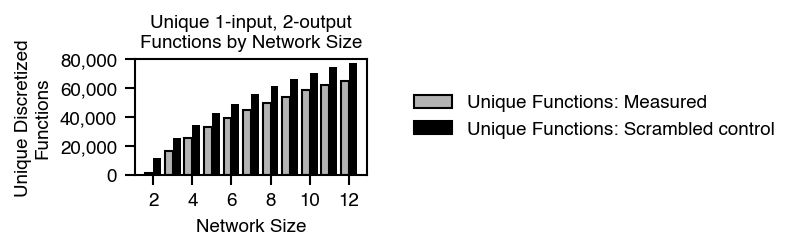

In [ ]:
save = True

fig, ax = plt.subplots(figsize=(2,1))

bar_width  = 0.4
# Real
ax.bar(np.array(m_list)-(bar_width/2),num_unique_voxels_2output_by_m,width=bar_width,facecolor=(0.7,0.7,0.7),edgecolor='k')
# Scrambled
ax.bar(np.array(m_list)+(bar_width/2),num_unique_voxels_2output_scrambled_by_m,width=bar_width,color='k')
# Total
# ax.bar(np.array(m_list),combos_counted_by_m,width=bar_width,color='k')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Unique Discretized\nFunctions')
_ = ax.set_title('Unique 1-input, 2-output\nFunctions by Network Size')
_ = ax.set_xticks(np.array(m_list)[::2])
_ = ax.set_xticklabels(np.array(m_list)[::2].astype(str))

# _ = ax.set_yscale('log')
# _ = ax.set_ylim([1,10000])
# _ = ax.set_yticks(np.logspace(0,4,4))
# set_simple_log_ticks(ax,which='y',log_lowerbound=0,log_upperbound=4,max_labels=4)

_ = ax.set_ylim([0,8e4])
_ = ax.set_yticks(np.linspace(0,8e4,5),labels=[f'{int(x):,}' for x in np.linspace(0,8e4,5)])

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
ax.tick_params(axis='both', which='minor', length=2.5, width=0.25)   # Length and linewidth of minor ticks

# Make legend
patches={}
patches[f'light'] = mpatches.Patch(facecolor=(0.7,0.7,0.7),edgecolor='k',label=f'Unique Functions: Measured')
patches[f'dark'] = mpatches.Patch(facecolor='k',edgecolor='k',label=f'Unique Functions: Scrambled control')
# patches[f'black'] = mpatches.Patch(color='k',edgecolor='none',label=f'All 2-output functions observed')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')

# plt.tight_layout()

if save:
    filename = f'FigS3G_num_unique_voxels_1input_2output_by_network_size'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Validation

### How many networks do we need to sample (via bootstrapping)? - Figure S3

Conclusion: We are not saturating our sampling; as we sample more networks, we continue to see more unique functions, but at a log-linear rate. This is likely due to discovering increasingly rare functions.

In [ ]:
# Load, if necessary
S_all_filenames_by_m = np.load(str(pathlib.Path(load_dir,'S_all_filenames_by_m.npy')),allow_pickle=True)
all_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'all_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
unfiltered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'unfiltered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
nonzero_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'nonzero_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
filtered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'filtered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)

In [ ]:
bootstrap_out_dir = str(pathlib.Path(out_dir,'bootstrap'))

if not os.path.isdir(bootstrap_out_dir):
    os.mkdir(bootstrap_out_dir)

In [ ]:
t = 30 # Number of input points to simulate
input_lb = -3 # Lower bound of input range in log scale
input_ub = 3 # Upper bound of input range in log scale

t_voxels = 6 # Number of input regions for calculating unique functions ('voxels')

In [ ]:
# Define voxels
boundaries = np.logspace(input_lb,input_ub,t_voxels+1,endpoint=True)[1:-1]

In [ ]:
load_dir = str(pathlib.Path('/','home','ubuntu','Data','20221108_1input_randomParamset'))

In [ ]:
m_list = list(range(2,13)) # Network sizes to analyze

In [ ]:
num_networks_to_test_list = [100, 500, 1000, 2500, 5000, 10000, 15000, 20000, 50000, 100000, 250000,500000,1000000]

num_replicates = 5

In [ ]:
num_networks_bootstrapped = {
    3: [],
    4: [],
    5: [],
    6: [],
    7: [],
    8: [],
    9: [],
    10: [],
    11: [],
    12: [],
}

num_unique_voxels_bootstrapped = {
    3: [],
    4: [],
    5: [],
    6: [],
    7: [],
    8: [],
    9: [],
    10: [],
    11: [],
    12: [],
}

Considering 100 networks, m=3
Considering 500 networks, m=3
Considering 1000 networks, m=3
Considering 2500 networks, m=3
Considering 5000 networks, m=3
Considering 10000 networks, m=3
Considering 15000 networks, m=3
Considering 20000 networks, m=3
Considering 50000 networks, m=3
Considering 100000 networks, m=3
Considering 250000 networks, m=3
Considering 500000 networks, m=3
Considering 1000000 networks, m=3
Finished m=3.
Considering 100 networks, m=4
Considering 500 networks, m=4
Considering 1000 networks, m=4
Considering 2500 networks, m=4
Considering 5000 networks, m=4
Considering 10000 networks, m=4
Considering 15000 networks, m=4
Considering 20000 networks, m=4
Considering 50000 networks, m=4
Considering 100000 networks, m=4
Considering 250000 networks, m=4
Considering 500000 networks, m=4
Considering 1000000 networks, m=4
Finished m=4.
Considering 100 networks, m=5
Considering 500 networks, m=5
Considering 1000 networks, m=5
Considering 2500 networks, m=5
Considering 5000 netwo

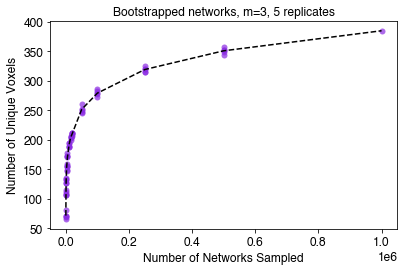

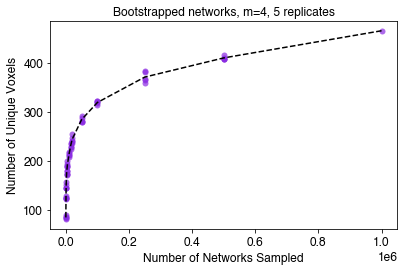

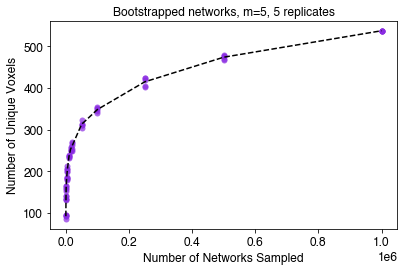

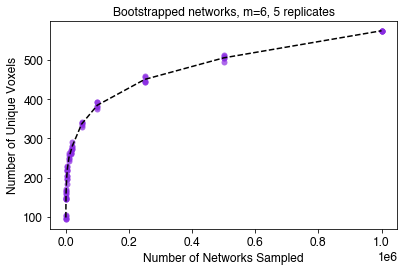

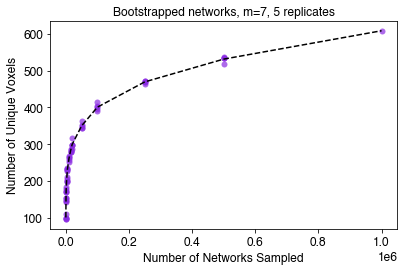

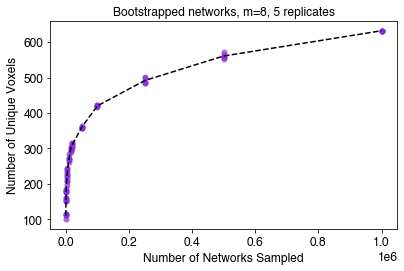

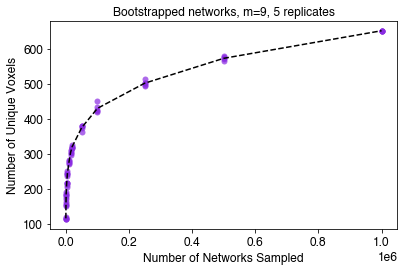

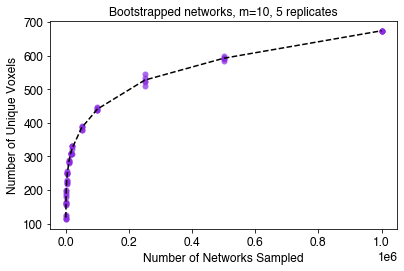

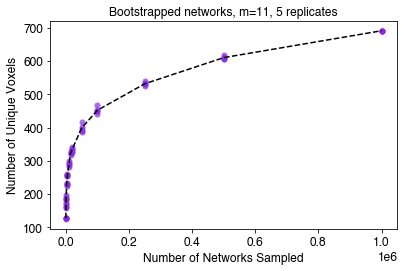

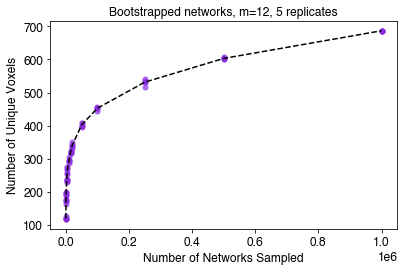

In [ ]:
for m_i,m in enumerate(m_list):
    specific_out_dir = str(pathlib.Path(bootstrap_out_dir,f'{m}M'))
    if not os.path.isdir(specific_out_dir):
        os.mkdir(specific_out_dir)
    
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M',f'K_A_param_sets.npy')),allow_pickle=True)
    curves_by_voxel = np.load(str(pathlib.Path(out_dir,f'{m}M_curves_by_voxel.npy')),allow_pickle=True)
    # Calculate unique_inverse mapping from curves to voxels
    unique_inverse = np.empty((np.sum(filtered_curves_per_Sall_chunk_by_m[m_i]),),dtype=np.int64)
    for voxel in range(curves_by_voxel.shape[0]):
        unique_inverse[curves_by_voxel[voxel]] = voxel
    
    unfiltered_curves_per_S_all_chunk = all_curves_per_Sall_chunk_by_m[m_i]
    curves_per_param_set = num_combos_with_replacement(m,r=2)

    num_S_all_chunks = len(S_all_filenames_by_m[m_i])
    
    # Iterate over different numbers of networks to test
    for num_networks_to_test in num_networks_to_test_list:
        if num_networks_to_test>param_sets.shape[0]:
            continue
        print(f"Considering {num_networks_to_test} networks, m={m}")
        seed=42
        
        # Adjust number of networks to test such that different connectivities may be sampled evenly
        num_possible_num_edges = num_combos(m,r=2) - (m-1) + 1
        num_sets_per_num_edges = math.ceil(num_networks_to_test/num_possible_num_edges)
        num_sets_per_num_edges_fullset = math.ceil(param_sets.shape[0]/num_possible_num_edges)
        num_networks_to_test = int(num_sets_per_num_edges*num_possible_num_edges)
        num_networks_to_test_fullset = int(num_sets_per_num_edges_fullset*num_possible_num_edges)
        if num_networks_to_test==num_networks_to_test_list[-1]:
            num_replicates_temp = 1
        else:
            num_replicates_temp = num_replicates
        # Iterate over replicates
        for replicate in range(num_replicates_temp):
            # Randomly subset
            rng = np.random.default_rng(seed=seed)
            seed+=1
            param_sets_subset = np.zeros((num_networks_to_test,),dtype=np.int64)
            # Sample parameter sets for each connectivity value
            for num_edges_i,num_edges in enumerate(range(m-1,num_combos(m,r=2)+1)):
                param_sets_subset[num_edges_i*num_sets_per_num_edges:((num_edges_i+1)*num_sets_per_num_edges)] =\
                    rng.choice(np.arange(num_edges_i*num_sets_per_num_edges_fullset,((num_edges_i+1)*num_sets_per_num_edges_fullset)),\
                               num_sets_per_num_edges,replace=False)
            curve_subset = np.array(list(itertools.chain.from_iterable(\
                            [list(range(param_set*curves_per_param_set,(param_set+1)*curves_per_param_set))\
                            for param_set in param_sets_subset]))) # Unfiltered IDs
            # Iterate over chunks of S_all (responses), which were saved separately
            for S_all_chunk in range(num_S_all_chunks):
                curve_subset_in_chunk = curve_subset[np.where((curve_subset>=np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk]))\
                                             & (curve_subset<np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk+1])))] # Unfiltered IDs
                if curve_subset_in_chunk.shape[0]==0:
                    continue
                curve_subset_in_chunk = (curve_subset_in_chunk-\
                                            np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64) # Unfiltered IDs, starting at 0 within chunk
                # S_all_processed_filtered = np.load(str(pathlib.Path(load_dir,f'{m}M',f'S_all_processed_filtered_{S_all_chunk}.npy')),allow_pickle=True)
                univ_filter_map_filename = str(pathlib.Path(load_dir,f'{m}M',f'univ_filter_map_{S_all_chunk}.npy'))
                univ_filter_map = np.load(str(pathlib.Path(load_dir,f'{m}M',univ_filter_map_filename)),allow_pickle=True)
                curve_subset_passed_filter = \
                    curve_subset_in_chunk[np.isin(curve_subset_in_chunk,univ_filter_map[:,0])] # Unfiltered IDs, starting at 0 within chunk, that passed filtering
                curve_subset_filtered = univ_filter_map[np.isin(univ_filter_map[:,0],curve_subset_passed_filter)][:,1] # Filtered IDs, starting at 0 within chunk
                # S_all_subset = S_all_processed_filtered[curve_subset_filtered,:]
                # Knowing the subset of curves, and which voxel each performs, calculate the unique voxels
                if S_all_chunk==0:
                    # If this is the first chunk, initialize unique_voxel_ids
                    unique_voxel_ids = np.unique(unique_inverse[(curve_subset_filtered+\
                                                                 np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64)])
                else:
                    # Otherwise, concatenate to unique_voxel_ids
                    unique_voxel_ids_temp = np.unique(unique_inverse[(curve_subset_filtered+\
                                                                 np.sum(filtered_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64)])
                    unique_voxel_ids = np.unique(np.concatenate((unique_voxel_ids,unique_voxel_ids_temp),\
                                                             axis=0),axis=0,return_inverse=False)
            num_networks_bootstrapped[m].append(num_networks_to_test)
            num_unique_voxels_bootstrapped[m].append(unique_voxel_ids.shape[0])
    
    np.save(str(pathlib.Path(specific_out_dir,f'num_networks_bootstrapped.npy')), num_networks_bootstrapped[m])
    np.save(str(pathlib.Path(specific_out_dir,f'num_unique_voxels_bootstrapped.npy')), num_unique_voxels_bootstrapped[m])
    

    # Plot
    fig, ax = plt.subplots()

    ax.plot(num_networks_bootstrapped[m],num_unique_voxels_bootstrapped[m],ls='', marker='.',ms=12,markeredgewidth=0,color='blueviolet',alpha=0.7)

    unique_num_networks = np.unique(num_networks_bootstrapped[m])
    avg_num_unique_voxels = [np.mean(np.array(num_unique_voxels_bootstrapped[m])\
                                [np.where(np.array(num_networks_bootstrapped[m])==size)])\
                                for size in unique_num_networks]
    ax.plot(unique_num_networks,avg_num_unique_voxels,ls='--', marker='',ms=12,color='k')

    _ = ax.set_xlabel('Number of Networks Sampled')
    _ = ax.set_ylabel('Number of Unique Voxels')
    _ = ax.set_title(f'Bootstrapped networks, m={m}, {num_replicates} replicates')
    fig.patch.set_facecolor('white')

    filename = f'num_unique_voxels_by_num_networks.png'
    plt.tight_layout()
    plt.savefig(str(pathlib.Path(specific_out_dir,filename)),dpi=900,bbox_inches='tight')

    ax.set_xscale('log')
    ax.set_yscale('linear')

    filename = f'num_unique_voxels_by_log_num_networks.png'
    plt.tight_layout()
    plt.savefig(str(pathlib.Path(specific_out_dir,filename)),dpi=900,bbox_inches='tight')

    ax.set_xscale('linear')
    ax.set_yscale('log')

    filename = f'log_num_unique_voxels_by_num_networks.png'
    plt.tight_layout()
    plt.savefig(str(pathlib.Path(specific_out_dir,filename)),dpi=900,bbox_inches='tight')

    ax.set_xscale('log')
    ax.set_yscale('log')

    filename = f'log_num_unique_voxels_by_log_num_networks.png'
    plt.tight_layout()
    plt.savefig(str(pathlib.Path(specific_out_dir,filename)),dpi=900,bbox_inches='tight')
    
    print(f"Finished m={m}.")

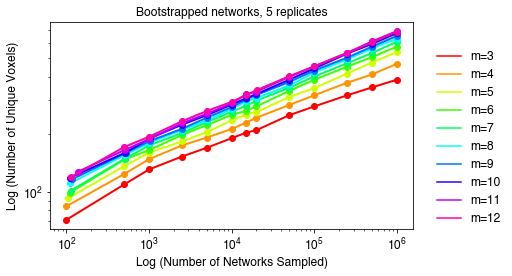

In [ ]:
fig, ax = plt.subplots()
cmap = plt.get_cmap('hsv')
for m_i,m in enumerate(m_list):
    specific_out_dir = str(pathlib.Path(bootstrap_out_dir,f'{m}M'))
    num_networks_bootstrapped = np.load(str(pathlib.Path(specific_out_dir,f'num_networks_bootstrapped.npy')), allow_pickle=True)
    num_unique_voxels_bootstrapped = np.load(str(pathlib.Path(specific_out_dir,f'num_unique_voxels_bootstrapped.npy')), allow_pickle=True)
    # ax.plot(num_networks_bootstrapped,num_unique_voxels_bootstrapped,ls='', marker='.',ms=12,markeredgewidth=0,color='blueviolet',alpha=0.7)
    unique_num_networks = np.unique(num_networks_bootstrapped)
    avg_num_unique_voxels = [np.mean(np.array(num_unique_voxels_bootstrapped)\
                                [np.where(np.array(num_networks_bootstrapped)==size)])\
                                for size in unique_num_networks]
    ax.plot(unique_num_networks,avg_num_unique_voxels,ls='-', marker='.',ms=12,lw=2,color=cmap(m_i/len(m_list)))

_ = ax.set_xlabel('Log (Number of Networks Sampled)')
_ = ax.set_ylabel('Log (Number of Unique Voxels)')
_ = ax.set_title(f'Bootstrapped networks, {num_replicates} replicates')
fig.patch.set_facecolor('white')

ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

patches = {}
for m_i, m in enumerate(m_list):
    patches[f'{m}'] = mlines.Line2D([],[],ls='-',color=cmap(m_i/len(m_list)),\
                                            label=f'm={m}')
leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
        handles=list(patches.values()),\
        edgecolor='white')

filename = f'num_unique_voxels_by_num_networks_all.png'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')